# Interpreting the Projection and Feed-Forward Layers in a Self-Attention Block

> A summary of my experiments to understand the projection layer and feed-forward layer of a self-attention block.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
import json
import math
from pathlib import Path
from typing import Dict, Optional, Iterable, Sequence, Tuple

In [ ]:
# | hide

from fastcore.test import *
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# Set a manual seed so output is deterministic (used same value as @karpathy)
_ = torch.manual_seed(1337)

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
    SubstringFrequencyAnalysis,
    top_nonzero_tokens
)
from transformer_experiments.common.utils import (
    aggregate_by_string_key,
    DataWrapper,
    topk_across_batches,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.models.transformer import (
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer
)
from transformer_experiments.experiments.block_internals import (
    BlockInternalsAccessors,
    BlockInternalsExperiment,
    BatchedBlockInternalsExperiment,
    BatchedBlockInternalsExperimentSlicer,
    BlockInternalsAnalysis,
)
from transformer_experiments.experiments.similar_strings import (
    SimilarStringsData,
    SimilarStringsExperiment,
    SimilarStringsResult
)
from transformer_experiments.experiments.logit_lens import LogitLens

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file='../artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename='../artifacts/shakespeare.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
print(f"device is {device}")

device is cpu


In [ ]:
# Define a block internals experiment with all the unique substrings in the
# Tiny Shakespeare dataset.
s_len = 3
exp = BlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=all_unique_substrings(ts.text, s_len),
)

In [ ]:
# For a specific prompt, print the probabilities of the 10 most likely next tokens
prompt = 'BAP'
tokens = encoding_helpers.tokenize_string(prompt)
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
for token, prob in logits.topk_tokens(k=10)[0][-1]:
    print(f'{repr(token)} {prob:.3f}')

'T' 0.376
'U' 0.296
'H' 0.066
':' 0.060
'E' 0.030
'R' 0.029
' ' 0.019
't' 0.017
'N' 0.017
'C' 0.012


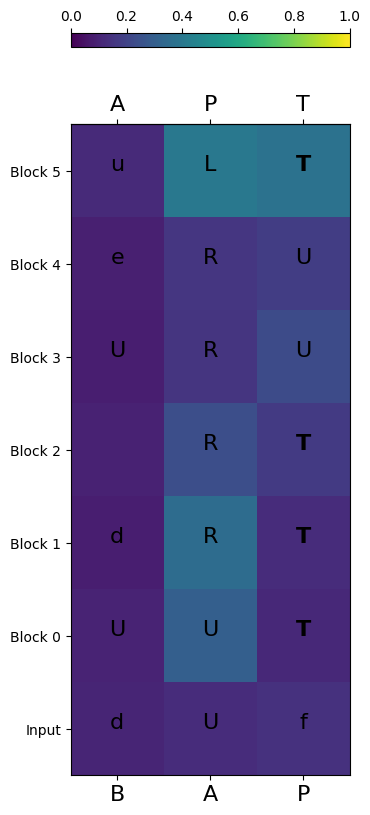

In [ ]:
# Show the logit lens view
logit_lens = LogitLens(encoding_helpers, accessors, 'BAP', 'APT')
logit_lens.plot()

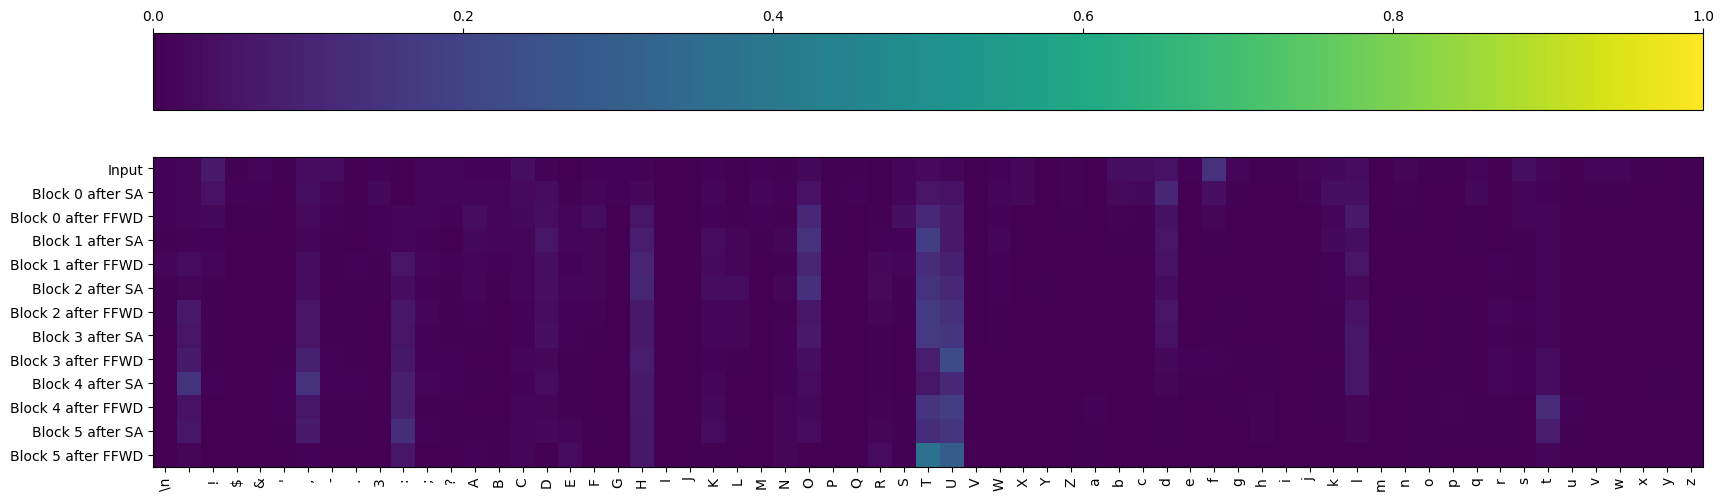

In [ ]:
# Show the block internals view
bia = BlockInternalsAnalysis(accessors, encoding_helpers, prompt=prompt)
bia.plot()

In [ ]:
# See how it plays out in practice.
prompt = 'BAP'
tokens = encoding_helpers.tokenize_string(prompt)
n_runs = 10
torch.manual_seed(1337)
for _ in range(n_runs):
    print(repr(tokenizer.decode(m.generate(tokens, max_new_tokens=5)[0].tolist())))

'BAPTIS:\n'
'BAPULET:'
'BAPTIS:\n'
'BAPTER:\n'
'BAPTIS:\n'
'BAPULET:'
'BAPTISTE'
'BAPTIS:\n'
'BAP:\nNow'
'BAPULET:'


In [ ]:
def find_topk_similar_values(
    target_value: torch.Tensor,
    all_values: torch.Tensor,
    k: int=10
):
    """Find the top k values in all_values that are closest to target_value."""
    assert all_values.dim() == 2, "all_values must be a 2D tensor"
    assert all_values.shape[1] == target_value.shape[0], (
        "all_values last dimension must equal target_value first dimension"
    )

    distances = torch.norm(all_values - target_value, dim=1)
    topk_distances, topk_indices = torch.topk(distances, k=k, largest=False)
    return topk_distances, topk_indices

In [ ]:
# Get the model's predictions from the input alone.
prompt_idx = exp.string_idx(prompt)
prompt_embedding = exp.embeddings[prompt_idx]

logits = accessors.logits_from_embedding(unsqueeze_emb(prompt_embedding))
logits = LogitsWrapper(logits, tokenizer)
for token, prob in logits.topk_tokens(k=10)[0][-1]:
    print(f'{repr(token)} {prob:.3f}')

'f' 0.142
'!' 0.071
'd' 0.047
'c' 0.039
's' 0.039
'b' 0.038
'C' 0.038
',' 0.033
'l' 0.031
'-' 0.031


In [ ]:
# Build a next token map
next_token_map3 = build_next_token_map(
    ts.text, prefix_len=3, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi
)

In [ ]:
# Find input embeddings that are similar to the prompt embedding
B, _, _ = exp.embeddings.shape

topk_distances, topk_indices = find_topk_similar_values(
    target_value=prompt_embedding.reshape(-1),
    all_values=exp.embeddings.reshape(B, -1),
    k=10
)

prompt_embedding.reshape(-1).shape, exp.embeddings.reshape(B, -1).shape
similar_strings = [exp.strings[i.item()] for i in topk_indices]

analysis = SubstringFrequencyAnalysis(
    similar_strings,
    next_token_map3,
    tokenizer.itos,
)
analysis.print_summary()

freqs = analysis.cumulative_freqs
top_nonzero_tokens(freqs.float() / freqs.sum(), tokenizer.itos)

Substrings: 'BAP', 'BAN', 'CAP', 'BAL', 'BAR', 'BAG', 'BAS', 'Bap', 'Bal', 'Bag'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'BAN':  ':' (   6)
   'CAP':  'U' (  95)
   'BAL':  'T' (  29)
   'BAR':  'N' (   7)
   'BAG':  'O' (   6)
   'BAS':  'T' (  42)
   'Bap':  't' (  30)
   'Bal':  't' (   1),  'm' (   1),  'k' (   1)
   'Bag':  'o' (   6)
Cumulative Top Tokens:
 'T' (0.48),  'U' (0.33),  't' (0.11),  'N' (0.02),  ':' (0.02),  'O' (0.02),  'o' (0.02),  'm' (0.00),  'k' (0.00)


[('T', 0.47602739930152893),
 ('U', 0.32534247636795044),
 ('t', 0.10616438090801239),
 ('N', 0.02397260256111622),
 (':', 0.02054794505238533),
 ('O', 0.02054794505238533),
 ('o', 0.02054794505238533),
 ('m', 0.0034246575087308884),
 ('k', 0.0034246575087308884)]

In [ ]:
prompt_idx = exp.string_idx(prompt)

proj_similars = []
proj_distances = []
ffwd_similars = []
ffwd_distances = []
for block_idx in range(n_layer):
    # Find the most similar proj outputs to the prompt
    proj_outputs = exp.proj_output(block_idx=block_idx)[:, -1]
    prompt_proj_output = proj_outputs[prompt_idx]
    topk_distances, topk_indices = find_topk_similar_values(
        target_value=prompt_proj_output,
        all_values=proj_outputs,
        k=10,
    )
    similar_strings = [exp.strings[i.item()] for i in topk_indices]
    proj_similars.append(similar_strings)
    proj_distances.append(topk_distances)

    # Find the most similar ffwd outputs to the prompt
    ffwd_outputs = exp.ffwd_output(block_idx=block_idx)[:, -1]
    prompt_ffwd_output = ffwd_outputs[prompt_idx]
    topk_distances, topk_indices = find_topk_similar_values(
        target_value=prompt_ffwd_output,
        all_values=ffwd_outputs,
        k=10,
    )
    similar_strings = [exp.strings[i.item()] for i in topk_indices]
    ffwd_similars.append(similar_strings)
    ffwd_distances.append(topk_distances)

In [ ]:
proj_similars, proj_distances

([['BAP', 'BAN', 'CAP', 'SAB', 'ZAB', '\nAB', 'BAL', ' AN', 'BAS', 'CAM'],
  ['BAP', 'BAN', 'BAR', 'BAS', 'BAL', 'BAG', 'Bac', 'Bas', 'Bad', 'Bag'],
  ['BAP', 'BAL', 'BAS', 'BAN', 'BAR', 'BAG', 'Bag', 'Bad', 'Ban', 'Bac'],
  ['BAP', 'BAN', 'BAG', 'BAS', 'BAL', 'BAR', 'BRA', "By'", 'Bay', 'Aba'],
  ['BAP', 'BAL', 'Bap', 'Bal', 'Bar', 'Boo', 'Bas', 'Bor', 'Bou', 'BAN'],
  ['BAP', 'BAS', 'BAR', 'BAL', 'BIS', 'But', 'BAG', 'Bov', 'BAN', 'Bis']],
 [tensor([0.0000, 2.6740, 3.0732, 3.0775, 3.1909, 3.3183, 3.3388, 3.5372, 3.7243,
          3.8754]),
  tensor([0.0000, 1.4399, 1.5282, 1.7506, 1.7877, 1.8182, 4.9871, 5.1028, 5.1815,
          5.1832]),
  tensor([0.0000, 2.1242, 2.2747, 2.3836, 2.4477, 3.4191, 4.1406, 4.2563, 4.3822,
          4.3824]),
  tensor([0.0000, 3.0834, 3.2525, 3.2979, 3.5543, 4.2748, 5.5574, 5.7777, 5.8512,
          5.8894]),
  tensor([0.0000, 3.0785, 3.0967, 3.1707, 3.2126, 3.3210, 3.3273, 3.3452, 3.3544,
          3.3825]),
  tensor([0.0000, 2.1212, 3.1185, 3.1313, 3.

In [ ]:
ffwd_similars, ffwd_distances

([['BAP', 'CAP', 'AMP', 'TEP', 'SEP', 'MOP', 'HOP', 'OMP', 'TOP', 'OOP'],
  ['BAP', 'CAP', 'MOP', 'TOP', 'SEP', 'TEP', 'HOP', 'AMP', 'OOP', 'OSP'],
  ['BAP', 'CAP', 'BAN', 'MOP', 'AMP', 'LAN', 'TOP', 'BAR', 'CAM', 'TEP'],
  ['BAP', 'BAL', 'BAR', 'CAP', 'BAG', 'ABE', 'Abe', 'BAN', 'abe', 'AMP'],
  ['BAP', 'BAL', 'CAP', 'DAM', 'BAG', 'bap', 'BAR', 'sep', 'Daz', 'epe'],
  ['BAP', 'BAS', 'OOP', 'bap', 'rap', 'Bap', ' Aj', 'orp', 'TOP', 'CAP']],
 [tensor([0.0000, 0.6644, 2.0406, 2.0776, 2.2129, 2.2171, 2.2722, 2.3273, 2.4016,
          2.6918]),
  tensor([0.0000, 3.5556, 5.6887, 5.7952, 5.9396, 5.9930, 6.1169, 6.2552, 6.6985,
          6.9018]),
  tensor([0.0000, 6.5570, 7.8843, 7.9948, 8.2203, 8.5468, 8.6237, 8.6576, 8.6716,
          8.6961]),
  tensor([ 0.0000,  9.7076,  9.7220,  9.8370,  9.8444,  9.8473,  9.9139,  9.9200,
           9.9386, 10.0016]),
  tensor([ 0.0000, 10.0889, 10.4197, 10.6212, 10.7716, 10.7758, 10.8574, 11.0253,
          11.0407, 11.0955]),
  tensor([ 0.0000, 12.949

In [ ]:
for similars in proj_similars:
    analysis = SubstringFrequencyAnalysis(
        similars,
        next_token_map3,
        tokenizer.itos,
    )
    analysis.print_summary()
    freqs += analysis.cumulative_freqs

Substrings: 'BAP', 'BAN', 'CAP', 'SAB', 'ZAB', '\nAB', 'BAL', ' AN', 'BAS', 'CAM'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'BAN':  ':' (   6)
   'CAP':  'U' (  95)
   'SAB':  'E' ( 129)
   'ZAB':  'E' ( 105)
  '\nAB':  'H' (  13),  'R' (   5)
   'BAL':  'T' (  29)
   ' AN':  'N' (  51)
   'BAS':  'T' (  42)
   'CAM':  'I' (  72)
Cumulative Top Tokens:
 'E' (0.38),  'T' (0.23),  'U' (0.15),  'I' (0.12),  'N' (0.08),  'H' (0.02),  ':' (0.01),  'R' (0.01)
Substrings: 'BAP', 'BAN', 'BAR', 'BAS', 'BAL', 'BAG', 'Bac', 'Bas', 'Bad', 'Bag'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'BAN':  ':' (   6)
   'BAR':  'N' (   7)
   'BAS':  'T' (  42)
   'BAL':  'T' (  29)
   'BAG':  'O' (   6)
   'Bac':  'k' (   4),  'c' (   1)
   'Bas':  'e' (   3),  't' (   2),  'i' (   1)
   'Bad':  ' ' (   4),  'e' (   1)
   'Bag':  'o' (   6)
Cumulative Top Tokens:
 'T' (0.77),  'N' (0.04),  ':' (0.03),  'o' (0.03),  'O' (0.03),  'k' (0.02),  'e' (0.02),  ' ' (0.02),  't' (0.01),  'c'

In [ ]:
for similars in ffwd_similars:
    analysis = SubstringFrequencyAnalysis(
        similars,
        next_token_map3,
        tokenizer.itos,
    )
    analysis.print_summary()
    freqs += analysis.cumulative_freqs

Substrings: 'BAP', 'CAP', 'AMP', 'TEP', 'SEP', 'MOP', 'HOP', 'OMP', 'TOP', 'OOP'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'CAP':  'U' (  95)
   'AMP':  'S' (  20)
   'TEP':  'H' (   6)
   'SEP':  'H' (   1)
   'MOP':  'S' (  13)
   'HOP':  ' ' (  17)
   'OMP':  'E' (  58),  'H' (   2)
   'TOP':  'H' (   2)
   'OOP':  ':' (   6)
Cumulative Top Tokens:
 'U' (0.33),  'T' (0.24),  'E' (0.20),  'S' (0.11),  ' ' (0.06),  'H' (0.04),  ':' (0.02)
Substrings: 'BAP', 'CAP', 'MOP', 'TOP', 'SEP', 'TEP', 'HOP', 'AMP', 'OOP', 'OSP'
Top Tokens for each substring:
   'BAP':  'T' (  68)
   'CAP':  'U' (  95)
   'MOP':  'S' (  13)
   'TOP':  'H' (   2)
   'SEP':  'H' (   1)
   'TEP':  'H' (   6)
   'HOP':  ' ' (  17)
   'AMP':  'S' (  20)
   'OOP':  ':' (   6)
   'OSP':  'E' (  63)
Cumulative Top Tokens:
 'U' (0.33),  'T' (0.23),  'E' (0.22),  'S' (0.11),  ' ' (0.06),  'H' (0.03),  ':' (0.02)
Substrings: 'BAP', 'CAP', 'BAN', 'MOP', 'AMP', 'LAN', 'TOP', 'BAR', 'CAM', 'TEP'
Top Tokens for e

In [ ]:
top_nonzero_tokens(freqs.float() / freqs.sum(), tokenizer.itos)

[('T', 0.3333333432674408),
 ('U', 0.19797064363956451),
 (' ', 0.1256476640701294),
 ('E', 0.07664076238870621),
 ('I', 0.031088082119822502),
 ('L', 0.027849741280078888),
 ('t', 0.02590673603117466),
 ('S', 0.025690846145153046),
 ('N', 0.023100173100829124),
 (':', 0.01619170978665352),
 (',', 0.01619170978665352),
 ('D', 0.01424870453774929),
 ('H', 0.014032815583050251),
 ('n', 0.01165803149342537),
 ('O', 0.009067357517778873),
 ('r', 0.00863557867705822),
 ('l', 0.006692573428153992),
 ('o', 0.004533678758889437),
 ('e', 0.0038860102649778128),
 ('a', 0.0038860102649778128),
 ('K', 0.0034542314242571592),
 ('i', 0.0030224525835365057),
 ('Y', 0.0028065629303455353),
 ('s', 0.0028065629303455353),
 ('k', 0.0023747840896248817),
 ('h', 0.002158894669264555),
 ('u', 0.0017271157121285796),
 ('R', 0.0010794473346322775),
 ('\n', 0.0008635578560642898),
 ('c', 0.0006476683774963021),
 ('d', 0.0006476683774963021),
 ('p', 0.0004317789280321449),
 ('.', 0.0004317789280321449),
 ('b', 

In [ ]:
def simulate(
    prompt: str,
    exp: BlockInternalsExperiment,
    encoding_helpers: EncodingHelpers,
    accessors: TransformerAccessors,
    next_token_map: Dict[str, torch.Tensor],
):
    tokenizer = encoding_helpers.tokenizer

    def freqs_from_similar_strings(similar_strings: Iterable[str]):
        analysis = SubstringFrequencyAnalysis(
            similar_strings, next_token_map, tokenizer.itos
        )
        return analysis.cumulative_freqs

    def get_similar_strings(
        target_value: torch.Tensor,
        all_values: torch.Tensor,
        k: int=10
    ):
        _, topk_indices = find_topk_similar_values(
            target_value=target_value,
            all_values=all_values,
            k=k,
        )
        return [exp.strings[i.item()] for i in topk_indices]

    n_similars = 10

    # Run the prompt through the model so we can get all the
    # intermediate values for the prompt. The prompt may not
    # have been in the experiment's strings, so we need to
    # do this.
    tokens = encoding_helpers.tokenize_string(prompt)
    prompt_embedding = accessors.embed_tokens(tokens)

    _, prompt_io_accessors = accessors.run_model(prompt_embedding)

    # Find input embeddings that are similar to the prompt embedding
    B, _, _ = exp.embeddings.shape

    similar_strings = get_similar_strings(
        target_value=prompt_embedding[0].reshape(-1),
        all_values=exp.embeddings.reshape(B, -1),
        k=n_similars,
    )
    freqs = freqs_from_similar_strings(similar_strings)

    for block_idx in range(n_layer):
        # Find the most similar proj outputs to the prompt
        proj_outputs = exp.proj_output(block_idx=block_idx)[:, -1]
        prompt_proj_output = prompt_io_accessors[block_idx].output('sa.proj')[0][-1]
        similar_strings = get_similar_strings(
            target_value=prompt_proj_output,
            all_values=proj_outputs,
            k=n_similars,
        )
        freqs += freqs_from_similar_strings(similar_strings)

        # Find the most similar ffwd outputs to the prompt
        ffwd_outputs = exp.ffwd_output(block_idx=block_idx)[:, -1]
        prompt_ffwd_output = prompt_io_accessors[block_idx].output('ffwd')[0][-1]
        similar_strings = get_similar_strings(
            target_value=prompt_ffwd_output,
            all_values=ffwd_outputs,
            k=n_similars,
        )
        freqs += (1 + block_idx) * freqs_from_similar_strings(similar_strings)

    # Compute the model's predictions:
    tokens = encoding_helpers.tokenize_string(prompt)
    logits, _ = m(tokens)
    logits = LogitsWrapper(logits, tokenizer)
    return top_nonzero_tokens(freqs.float() / freqs.sum(), tokenizer.itos)[:10], logits.topk_tokens(k=10)[0][-1]

In [ ]:
simulate('BAP', exp, encoding_helpers, accessors, next_token_map3)

([('T', 0.3243669271469116),
  ('U', 0.2630801200866699),
  (' ', 0.0607941672205925),
  ('L', 0.05084244906902313),
  ('E', 0.04118632525205612),
  ('t', 0.03379643335938454),
  ('I', 0.02837718091905117),
  ('S', 0.027391862124204636),
  ('D', 0.019509311765432358),
  ('r', 0.018425460904836655)],
 [('T', 0.3757534921169281),
  ('U', 0.29568296670913696),
  ('H', 0.06634116172790527),
  (':', 0.06012270599603653),
  ('E', 0.029964493587613106),
  ('R', 0.029182784259319305),
  (' ', 0.018561311066150665),
  ('t', 0.016756560653448105),
  ('N', 0.016713792458176613),
  ('C', 0.01194547489285469)])

In [ ]:
simulate('Fir', exp, encoding_helpers, accessors, next_token_map3)

([('s', 0.5759245753288269),
  ('e', 0.15355785191059113),
  (' ', 0.04927520081400871),
  ('m', 0.03891307860612869),
  (',', 0.038086313754320145),
  ('t', 0.028275368735194206),
  ('i', 0.028220249339938164),
  ('d', 0.017527421936392784),
  ('l', 0.012181006371974945),
  ('r', 0.012125888839364052)],
 [('s', 0.9917504191398621),
  (' ', 0.0029867461416870356),
  ('m', 0.002403548453003168),
  ('e', 0.001212369417771697),
  ('d', 0.0005165351321920753),
  ('t', 0.00018800597172230482),
  (',', 0.00016302602307405323),
  (':', 7.246402674354613e-05),
  ('g', 6.890708755236119e-05),
  ('z', 6.84931583236903e-05)])

In [ ]:
simulate('Cit', exp, encoding_helpers, accessors, next_token_map3)

([('i', 0.30492648482322693),
  ('y', 0.19287854433059692),
  ('h', 0.16563305258750916),
  ('e', 0.11358093470335007),
  (' ', 0.05365479737520218),
  ('t', 0.029823705554008484),
  ('I', 0.0194411538541317),
  ('s', 0.017768796533346176),
  ('o', 0.017281025648117065),
  ('c', 0.015887394547462463)],
 [('i', 0.8416081666946411),
  ('y', 0.08598577231168747),
  ('e', 0.03443723917007446),
  ('a', 0.012056170031428337),
  ('h', 0.006880255416035652),
  (' ', 0.005409856326878071),
  ('o', 0.003821917809545994),
  ('l', 0.0014970063930377364),
  ('c', 0.001315052853897214),
  ('s', 0.0011799331987276673)])

In [ ]:
simulate('Mar', exp, encoding_helpers, accessors, next_token_map3)

([('r', 0.22357723116874695),
  ('c', 0.15401479601860046),
  ('k', 0.0868731141090393),
  ('v', 0.08198593556880951),
  ('e', 0.06106695905327797),
  ('i', 0.047547273337841034),
  ('t', 0.0471818745136261),
  ('s', 0.047136202454566956),
  ('g', 0.045765962451696396),
  (' ', 0.03676806390285492)],
 [('c', 0.45657357573509216),
  ('g', 0.1392820030450821),
  ('i', 0.09480810910463333),
  ('q', 0.07198260724544525),
  ('r', 0.05351363494992256),
  ('k', 0.03357788920402527),
  ('s', 0.02921028807759285),
  ('t', 0.025271940976381302),
  ('v', 0.020283378660678864),
  ('p', 0.013849235139787197)])

In [ ]:
simulate('arc', exp, encoding_helpers, accessors, next_token_map3)

([('e', 0.22243662178516388),
  (' ', 0.1906214952468872),
  ('h', 0.12730535864830017),
  ('i', 0.11539152264595032),
  (',', 0.047251515090465546),
  ('y', 0.04332510754466057),
  ('a', 0.042158402502536774),
  ('s', 0.036078080534935),
  ('u', 0.029459277167916298),
  ('o', 0.022212250158190727)],
 [('h', 0.8696205615997314),
  ('e', 0.07215109467506409),
  ('i', 0.03782087564468384),
  ('o', 0.006874476559460163),
  ('y', 0.003423927817493677),
  ('a', 0.002202593954280019),
  ('u', 0.0016430942341685295),
  (' ', 0.0013816507998853922),
  ('s', 0.0006439642747864127),
  ('l', 0.0006395326927304268)])

In [ ]:
# Run simulate() on a bunch of random strings and collect the output
n_samples = 1000

# Get `n_samples` random strings from the 5 length experiment
torch.manual_seed(1337)
indices = torch.randperm(len(exp.strings))[:n_samples]
strings = [exp.strings[i.item()] for i in indices]

results3 = {}
for s in tqdm(strings):
    sim_output, model_output = simulate(s, exp, encoding_helpers, accessors, next_token_map3)
    results3[s] = (sim_output, model_output)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def analyze_simulate_results(results: Dict[str, Tuple[Sequence, Sequence]]):
    n_samples = len(results)
    top1_token_matches_count = 0
    top1_token_match_failures = []

    top2_token_matches_count = 0
    top2_token_match_failures = []

    top3_token_matches_count = 0
    top3_token_match_failures = []

    top1_token_matches_and_top3_tokens_same_count = 0
    top1_token_matches_and_top3_tokens_same_failures = []

    top2_tokens_same_any_order_count = 0
    top2_tokens_same_any_order_failures = []

    top3_tokens_same_any_order_count = 0
    top3_tokens_same_any_order_failures = []

    for s, (sim_output, model_output) in results.items():
        sim_tokens, _ = zip(*sim_output)
        model_tokens, _ = zip(*model_output)
        if sim_tokens[0] == model_tokens[0]:
            top1_token_matches_count += 1
            if set(sim_tokens[:3]) == set(model_tokens[:3]):
                top1_token_matches_and_top3_tokens_same_count += 1
            else:
                top1_token_matches_and_top3_tokens_same_failures.append(s)
        else:
            top1_token_match_failures.append(s)

        if sim_tokens[:2] == model_tokens[:2]:
            top2_token_matches_count += 1
        else:
            top2_token_match_failures.append(s)

        if sim_tokens[:3] == model_tokens[:3]:
            top3_token_matches_count += 1
        else:
            top3_token_match_failures.append(s)

        if set(sim_tokens[:2]) == set(model_tokens[:2]):
            top2_tokens_same_any_order_count += 1
        else:
            top2_tokens_same_any_order_failures.append(s)

        if set(sim_tokens[:3]) == set(model_tokens[:3]):
            top3_tokens_same_any_order_count += 1
        else:
            top3_tokens_same_any_order_failures.append(s)

    print(f"Top 1 token matches: {top1_token_matches_count / n_samples:.3f}")
    print(f"Top 2 token matches: {top2_token_matches_count / n_samples:.3f}")
    print(f"Top 3 token matches: {top3_token_matches_count / n_samples:.3f}")
    print(f"Top 1 token matches and top 3 tokens same: {top1_token_matches_and_top3_tokens_same_count / n_samples:.3f}")
    print(f"Top 2 tokens same (any order): {top2_tokens_same_any_order_count / n_samples:.3f}")
    print(f"Top 3 tokens same (any order): {top3_tokens_same_any_order_count / n_samples:.3f}")

    return top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures

In [ ]:
top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures = analyze_simulate_results(results3)

Top 1 token matches: 0.597
Top 2 token matches: 0.322
Top 3 token matches: 0.123
Top 1 token matches and top 3 tokens same: 0.171
Top 2 tokens same (any order): 0.405
Top 3 tokens same (any order): 0.243


In [ ]:
# See how this does with longer prompts
exp5 = BlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=all_unique_substrings(ts.text, 5),
)

In [ ]:
next_token_map5 = build_next_token_map(
    ts.text, prefix_len=5, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi
)

In [ ]:
simulate('shyam', exp5, encoding_helpers, accessors, next_token_map5)

([('e', 0.524142324924469),
  (' ', 0.13595934212207794),
  (',', 0.10895806550979614),
  ('.', 0.03208386152982712),
  ('b', 0.023189326748251915),
  ('s', 0.019695043563842773),
  ("'", 0.019059721380472183),
  ('\n', 0.01683608628809452),
  ('i', 0.016518425196409225),
  ('p', 0.013341804035007954)],
 [('e', 0.8080525994300842),
  (' ', 0.08855170756578445),
  (',', 0.023519359529018402),
  ('.', 0.017470987513661385),
  ("'", 0.010048294439911842),
  (':', 0.009866581298410892),
  ('p', 0.008247210644185543),
  ('s', 0.007062970660626888),
  (';', 0.005611235275864601),
  ('i', 0.004027177579700947)])

In [ ]:
simulate('ereby', exp5, encoding_helpers, accessors, next_token_map5)

([(' ', 0.4073884189128876),
  (',', 0.2124166190624237),
  ('\n', 0.056439198553562164),
  (';', 0.05079527944326401),
  ('.', 0.04155977442860603),
  ('e', 0.038481272757053375),
  ('l', 0.0292457677423954),
  ('o', 0.028219599276781082),
  (':', 0.027193432673811913),
  ('?', 0.023601846769452095)],
 [(' ', 0.47169485688209534),
  (',', 0.26089540123939514),
  ('.', 0.06965486705303192),
  (':', 0.06214312091469765),
  ('\n', 0.0447605662047863),
  (';', 0.03800647705793381),
  ('?', 0.027084456756711006),
  ('!', 0.019704341888427734),
  ('-', 0.00319221755489707),
  ("'", 0.002469274215400219)])

In [ ]:
# Check if the intermediate values are the same for the 3 and 5 length experiments
bap_idx = exp.string_idx('BAP')
bapti_idx = exp5.string_idx('BAPTI')

block_idx = 3
test_close(exp.block_input(block_idx=block_idx)[bap_idx], exp5.block_input(block_idx=block_idx)[bapti_idx][:3])
test_close(exp.proj_output(block_idx=block_idx)[bap_idx], exp5.proj_output(block_idx=block_idx)[bapti_idx][:3])
test_close(exp.ffwd_output(block_idx=block_idx)[bap_idx], exp5.ffwd_output(block_idx=block_idx)[bapti_idx][:3])
test_close(exp.block_output(block_idx=block_idx)[bap_idx], exp5.block_output(block_idx=block_idx)[bapti_idx][:3])

In [ ]:
prompt = 'ereby'
prompt_idx = exp5.string_idx(prompt)

proj_similars = []
proj_distances = []
ffwd_similars = []
ffwd_distances = []
for block_idx in range(n_layer):
    # Find the most similar proj outputs to the prompt
    proj_outputs = exp5.proj_output(block_idx=block_idx)[:, -1]
    prompt_proj_output = proj_outputs[prompt_idx]
    topk_distances, topk_indices = find_topk_similar_values(
        target_value=prompt_proj_output,
        all_values=proj_outputs,
        k=10,
    )
    similar_strings = [exp5.strings[i.item()] for i in topk_indices]
    proj_similars.append(similar_strings)
    proj_distances.append(topk_distances)

    # Find the most similar ffwd outputs to the prompt
    ffwd_outputs = exp5.ffwd_output(block_idx=block_idx)[:, -1]
    prompt_ffwd_output = ffwd_outputs[prompt_idx]
    topk_distances, topk_indices = find_topk_similar_values(
        target_value=prompt_ffwd_output,
        all_values=ffwd_outputs,
        k=10,
    )
    similar_strings = [exp5.strings[i.item()] for i in topk_indices]
    ffwd_similars.append(similar_strings)
    ffwd_distances.append(topk_distances)

In [ ]:
proj_similars, proj_distances

([['ereby',
   'eyebr',
   'reybe',
   ' rebe',
   'eyeba',
   'drybe',
   ' reba',
   'raybe',
   '\nrebe',
   'plebe'],
  ['ereby',
   'trebl',
   'elebr',
   'eyeba',
   ' reba',
   '\nrebe',
   '\nrebu',
   'feebl',
   ' rebe',
   'etebo'],
  ['ereby',
   'ereth',
   'ere b',
   'erbea',
   'ereto',
   'ereta',
   'ebels',
   'erewi',
   'eyeba',
   'eebly'],
  ['ereby',
   "erb'd",
   'eremp',
   'erest',
   'eress',
   'eyeba',
   'erely',
   'erend',
   "erea'",
   'eebly'],
  ['ereby',
   'erby.',
   'erely',
   'eres,',
   'ere I',
   'erenc',
   'erewi',
   'ereab',
   'ereso',
   'ebel,'],
  ['ereby',
   'erely',
   'eress',
   'erent',
   'erend',
   'erest',
   'ereft',
   'erect',
   'erers',
   'ereat']],
 [tensor([0.0000, 1.6044, 1.6646, 1.6827, 1.6979, 1.7379, 1.7963, 1.8674, 1.8796,
          1.9694]),
  tensor([0.0000, 3.4034, 3.7892, 3.8900, 4.1882, 4.1937, 4.2143, 4.5618, 4.6131,
          4.6833]),
  tensor([0.0000, 5.4911, 5.5688, 5.7148, 5.7923, 5.8070, 5.8202, 

In [ ]:
ffwd_similars, ffwd_distances

([['ereby',
   'Derby',
   'rosby',
   'desby',
   'tesby',
   'llaby',
   ' Siby',
   ' Liby',
   '-baby',
   'd aby'],
  ['ereby',
   'Derby',
   'desby',
   'tesby',
   'llaby',
   ' Liby',
   'ughby',
   'rosby',
   'd aby',
   ' Siby'],
  ['ereby',
   'Derby',
   'desby',
   'tesby',
   'rosby',
   ' Liby',
   ' Siby',
   'ughby',
   'hobby',
   'd aby'],
  ['ereby',
   'tesby',
   'desby',
   'Derby',
   'rosby',
   'ughby',
   'bbery',
   'llaby',
   'emory',
   'sbury'],
  ['ereby',
   'desby',
   'tesby',
   'enemy',
   'ughby',
   ' espy',
   'd aby',
   'abeth',
   'ebel,',
   'eemly'],
  ['ereby',
   'ughby',
   'chery',
   'ls by',
   'es by',
   'ys by',
   'egory',
   'el by',
   'rs by',
   'icery']],
 [tensor([0.0000, 0.3647, 0.4228, 0.4305, 0.4341, 0.5136, 0.5150, 0.5720, 0.5798,
          0.5856]),
  tensor([0.0000, 2.8526, 3.7321, 3.8184, 3.8346, 3.9576, 3.9813, 4.0179, 4.0477,
          4.2172]),
  tensor([0.0000, 5.6417, 5.8248, 5.9586, 6.8560, 7.7367, 7.7780, 7.7

In [ ]:
# Run simulate() on a bunch of random strings and collect the output
n_samples = 1000

# Get `n_samples` random strings from the 5 length experiment
torch.manual_seed(1337)
indices = torch.randperm(len(exp5.strings))[:n_samples]
strings = [exp5.strings[i.item()] for i in indices]

results5 = {}
for s in tqdm(strings):
    sim_output, model_output = simulate(s, exp5, encoding_helpers, accessors, next_token_map5)
    results5[s] = (sim_output, model_output)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures = analyze_simulate_results(results5)

Top 1 token matches: 0.770
Top 2 token matches: 0.470
Top 3 token matches: 0.206
Top 1 token matches and top 3 tokens same: 0.272
Top 2 tokens same (any order): 0.565
Top 3 tokens same (any order): 0.361


In [ ]:
len(top1_token_match_failures), len(top3_token_match_failures), len(top1_token_matches_and_top3_tokens_same_failures), len(top3_tokens_same_any_order_failures)

(230, 794, 498, 639)

In [ ]:
idx = 1
print(repr(top1_token_match_failures[idx]))
simulate(top1_token_match_failures[idx], exp5, encoding_helpers, accessors, next_token_map5)

'\n\nMIR'


([('C', 0.3050413131713867),
  ('A', 0.1362859606742859),
  ('I', 0.1307319849729538),
  ('T', 0.11563657224178314),
  ('G', 0.08544573932886124),
  ('E', 0.07448020577430725),
  ('N', 0.02905155159533024),
  (' ', 0.023497579619288445),
  (':', 0.01723155751824379),
  ('D', 0.015237824060022831)],
 [('G', 0.9023593664169312),
  ('C', 0.020130787044763565),
  ('E', 0.01697480119764805),
  ('T', 0.011545127257704735),
  ('S', 0.007779331412166357),
  ('D', 0.006875296588987112),
  ('W', 0.00641448562964797),
  ('I', 0.0059611317701637745),
  ('R', 0.004623779561370611),
  (' ', 0.0033937140833586454)])

In [ ]:
# try with 10000 samples
# Run simulate() on a bunch of random strings and collect the output
n_samples = 10000

# Get `n_samples` random strings from the 5 length experiment
torch.manual_seed(1337)
indices = torch.randperm(len(exp5.strings))[:n_samples]
strings = [exp5.strings[i.item()] for i in indices]

results5_10k = {}
for s in tqdm(strings):
    sim_output, model_output = simulate(s, exp5, encoding_helpers, accessors, next_token_map5)
    results5_10k[s] = (sim_output, model_output)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures = analyze_simulate_results(results5_10k)

Top 1 token matches: 0.761
Top 2 token matches: 0.437
Top 3 token matches: 0.180
Top 1 token matches and top 3 tokens same: 0.251
Top 2 tokens same (any order): 0.534
Top 3 tokens same (any order): 0.334


In [ ]:
if list(Path('../artifacts/block_internals_results/large_files/slen3/').glob('*')) == []:
    print("Run `make block_internals_slen3_dataset` in the project root to generate the required dataset")

In [ ]:
exp_batch_3 = BatchedBlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=exp.strings,
    output_dir=Path('../artifacts/block_internals_results/large_files/slen3/'),
    batch_size=10000,
)
bap = BlockInternalsAccessors('BAP', encoding_helpers, accessors)
block_idx=5
strings, distances = exp_batch_3.strings_with_topk_closest_proj_outputs(
    block_idx=block_idx,
    t_i=-1,
    query=bap.proj_output(block_idx=block_idx)[0][-1],
    k=10,
    largest=False
)
strings, distances

(['BAP', 'BAS', 'BAR', 'BAL', 'BIS', 'But', 'BAG', 'Bov', 'BAN', 'Bis'],
 tensor([0.0000, 2.1212, 3.1185, 3.1313, 3.4366, 3.4834, 3.5196, 3.6359, 3.6490,
         3.6613]))

In [ ]:
strings, distances = exp_batch_3.strings_with_topk_closest_embeddings(
    query=bap.input_embedding()[0],
    k=10,
    largest=False
)
strings, distances

(['BAP', 'BAN', 'CAP', 'BAL', 'BAR', 'BAG', 'BAS', 'Bap', 'Bal', 'Bag'],
 tensor([ 0.0000, 26.6075, 27.1806, 27.7169, 28.1656, 28.3661, 29.2551, 36.3127,
         36.5268, 36.6473]))

In [ ]:
strings, distances = exp_batch_3.strings_with_topk_closest_ffwd_outputs(
    block_idx=2,
    t_i=-1,
    query=bap.ffwd_output(block_idx=2)[0][-1],
    k=10,
    largest=False
)
strings, distances

(['BAP', 'CAP', 'BAN', 'MOP', 'AMP', 'LAN', 'TOP', 'BAR', 'CAM', 'TEP'],
 tensor([0.0000, 6.5570, 7.8843, 7.9948, 8.2203, 8.5468, 8.6237, 8.6576, 8.6716,
         8.6961]))

In [ ]:
strings10 = all_unique_substrings(ts.text, 10)

In [ ]:
next_token_map10 = build_next_token_map(
    ts.text, prefix_len=10, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi
)

In [ ]:
if list(Path('../artifacts/block_internals_results/large_files/slen10/').glob('*')) == []:
    print("Run `make block_internals_slen10_dataset` in the project root to generate the required dataset")

In [ ]:
exp10 = BatchedBlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=strings10,
    output_dir=Path('../artifacts/block_internals_results/large_files/slen10/'),
    batch_size=10000,
)

In [ ]:
# Run a similar strings experiment on a bunch of sample strings we'll use for analysis
output_dir = Path('../artifacts/block_internals_results/similar_strings_sample')
output_dir.mkdir(exist_ok=True)

ssexp = SimilarStringsExperiment(output_dir, encoding_helpers)
strings = ['First Citi', 'Citizen:\nB', 'Shyamalan ', 'more in jo']
batch_size=len(strings)
if not (output_dir / 'string_to_batch_map.json').exists():
    ssexp.generate_string_to_batch_map(strings, batch_size)

try:
    _ = next(iter(output_dir.glob('embs_sim_strings-*.json')))
except StopIteration:
    ssexp.generate_embeddings_files(strings, accessors, exp10, batch_size=batch_size, n_similars=10)

try:
    _ = next(iter(output_dir.glob('proj_out_sim_strings-*.json')))
except StopIteration:
    ssexp.generate_proj_out_files(strings, t_i=-1, accessors=accessors, exp=exp10, batch_size=batch_size, n_similars=10)

try:
    _ = next(iter(output_dir.glob('ffwd_out_sim_strings-*.json')))
except StopIteration:
    ssexp.generate_ffwd_out_files(strings, t_i=-1, accessors=accessors, exp=exp10, batch_size=batch_size, n_similars=10)


In [ ]:
class SimulationFromSimilarStringsExperimentResults:
    def __init__(
        self,
        ss_results: Dict[str, SimilarStringsResult],
        next_token_map: Dict[str, torch.Tensor],
        encoding_helpers: EncodingHelpers,
        aggregate_over_t_is: Sequence[int] = [-1],
    ):
        self.ss_results = ss_results
        self.next_token_map = next_token_map
        self.encoding_helpers = encoding_helpers
        self.aggregate_over_t_is = aggregate_over_t_is
        (
            self.string_to_idx,
            self.emb_freqs,
            self.proj_freqs,
            self.ffwd_freqs,
        ) = self._freqs_for_results()

    def simulate(self, prompt: str):
        if prompt not in self.ss_results:
            raise ValueError(
                f"Prompt {repr(prompt)} was not in the SimilarStringsExperiment results"
            )

        prompt_idx = self.string_to_idx[prompt]

        emb_weight = torch.tensor(1.0, dtype=torch.float32)
        proj_weights = torch.tensor(
            [1.0 for _ in range(n_layer)], dtype=torch.float32
        ).unsqueeze(dim=1)
        ffwd_weights = torch.tensor(
            [1 + block_idx for block_idx in range(n_layer)], dtype=torch.float32
        ).unsqueeze(dim=1)

        # this is what simulate does:
        freqs = (
            emb_weight * self.emb_freqs[prompt_idx, :]
            + (proj_weights * self.proj_freqs[:, prompt_idx, :]).sum(dim=0)
            + (ffwd_weights * self.ffwd_freqs[:, prompt_idx, :]).sum(dim=0)
        )
        sim_from_weights = top_nonzero_tokens(
            freqs.float() / freqs.sum(), self.encoding_helpers.tokenizer.itos
        )[:10]

        # Compute the model's predictions:
        tokens = self.encoding_helpers.tokenize_string(prompt)
        logits, _ = m(tokens)

        logits = LogitsWrapper(logits, self.encoding_helpers.tokenizer)
        return sim_from_weights, logits.topk_tokens(k=10)[0][-1]

    def _freqs_for_results(self):
        string_to_idx: Dict[str, int] = {}
        emb_freqs = []
        proj_freqs = [[] for _ in range(n_layer)]
        ffwd_freqs = [[] for _ in range(n_layer)]

        itos = self.encoding_helpers.tokenizer.itos

        for i, (s, result) in enumerate(self.ss_results.items()):
            string_to_idx[s] = i
            emb_freqs.append(
                SubstringFrequencyAnalysis(
                    result.embs.sim_strings, self.next_token_map, itos
                ).cumulative_freqs
            )
            aggr_proj_out, aggr_ffwd_out = result.aggregate_over_t_is(self.aggregate_over_t_is)

            for block_idx in range(n_layer):
                proj_freqs[block_idx].append(
                    SubstringFrequencyAnalysis(
                        aggr_proj_out[block_idx].sim_strings,
                        self.next_token_map,
                        itos,
                    ).cumulative_freqs
                )
                ffwd_freqs[block_idx].append(
                    SubstringFrequencyAnalysis(
                        aggr_ffwd_out[block_idx].sim_strings,
                        self.next_token_map,
                        itos,
                    ).cumulative_freqs
                )
        return (
            string_to_idx,
            torch.stack(emb_freqs),  # (len(ss_results), vocab_size)
            torch.stack(
                [torch.stack(freqs) for freqs in proj_freqs]
            ),  # (n_layer, len(ss_results), vocab_size)
            torch.stack(
                [torch.stack(freqs) for freqs in ffwd_freqs]
            ),  # (n_layer, len(ss_results), vocab_size)
        )

In [ ]:
ss_results = ssexp.load_results_for_strings(strings)

ss_sim = SimulationFromSimilarStringsExperimentResults(ss_results, next_token_map10, encoding_helpers)

In [ ]:
exp10_slicer = BatchedBlockInternalsExperimentSlicer(
    exp10, exp10.output_dir / 'slices', t_i=-1, combine_n_batches=20
)
exp10_slicer.create_slices_if_needed()

In [ ]:
strings10[14423:14433]

['more in jo',
 'ore in joy',
 're in joy ',
 'e in joy a',
 ' in joy at',
 'in joy at ',
 'n joy at f',
 ' joy at fi',
 'joy at fir',
 'oy at firs']

In [ ]:
ss_sim.simulate('First Citi')

([('z', 0.9380468726158142),
  ('i', 0.03080154024064541),
  ('e', 0.01610080525279045),
  ('c', 0.004550227429717779),
  ('h', 0.003850192530080676),
  ('p', 0.002100104931741953),
  (':', 0.0014000700321048498),
  ('o', 0.0014000700321048498),
  ('u', 0.0007000350160524249),
  (' ', 0.0007000350160524249)],
 [('z', 0.9996668100357056),
  ('u', 0.00010660554107744247),
  ('I', 7.993520557647571e-05),
  ('U', 2.734881672949996e-05),
  ('K', 2.4257360564661212e-05),
  ('P', 1.5074498151079752e-05),
  ('L', 1.0885321898967959e-05),
  ('n', 8.451069334114436e-06),
  ('O', 8.223939403251279e-06),
  ('f', 7.135453870432684e-06)])

In [ ]:
ss_sim.simulate('Citizen:\nB')

([('e', 0.3421829044818878),
  ('u', 0.17404130101203918),
  ('o', 0.13716813921928406),
  ('h', 0.09587020426988602),
  ('y', 0.08554572612047195),
  ('a', 0.07669616490602493),
  ('n', 0.033923305571079254),
  ('i', 0.028023598715662956),
  ('r', 0.011799409985542297),
  ('t', 0.007374631240963936)],
 [('e', 0.47825106978416443),
  ('u', 0.2509588301181793),
  ('y', 0.1266946792602539),
  ('r', 0.05788085237145424),
  ('i', 0.03135434538125992),
  ('o', 0.02440422773361206),
  ('a', 0.017102370038628578),
  ('l', 0.012891546823084354),
  ('s', 8.761954813962802e-05),
  ('R', 7.359156006714329e-05)])

In [ ]:
ss_sim.simulate('Shyamalan ')

([('t', 0.15815085172653198),
  ('b', 0.1228710487484932),
  ('o', 0.11313868314027786),
  ('a', 0.10340632498264313),
  ('i', 0.09975668787956238),
  ('d', 0.058394160121679306),
  ('s', 0.05352798104286194),
  ('w', 0.04866180196404457),
  ('m', 0.03041362576186657),
  ('f', 0.027980534359812737)],
 [('t', 0.16370470821857452),
  ('s', 0.10785210877656937),
  ('a', 0.09744462370872498),
  ('b', 0.09677103161811829),
  ('c', 0.08353256434202194),
  ('m', 0.056587863713502884),
  ('d', 0.048968441784381866),
  ('p', 0.04876013845205307),
  ('h', 0.04751131683588028),
  ('w', 0.038983285427093506)])

In [ ]:
ss_sim.simulate('more in jo')

([('y', 0.6007066965103149),
  ('t', 0.16607773303985596),
  ('i', 0.07773851603269577),
  ('s', 0.06713780760765076),
  ('u', 0.038869258016347885),
  ('m', 0.017667844891548157),
  ('d', 0.010600706562399864),
  ('r', 0.007067137863487005),
  ('k', 0.0035335689317435026),
  ('l', 0.0035335689317435026)],
 [('y', 0.8568735718727112),
  ('i', 0.06098264083266258),
  ('u', 0.04135835915803909),
  ('c', 0.016126777976751328),
  ('t', 0.012861563824117184),
  ('l', 0.0022685928270220757),
  ('o', 0.0021818610839545727),
  ('s', 0.0016513006994500756),
  ('v', 0.001559981144964695),
  ('w', 0.0011889823945239186)])

In [ ]:
# Run simulate() on a bunch of random strings and collect the output
n_samples = 900

# Get `n_samples` random strings from the 5 length experiment
torch.manual_seed(1337)
indices = torch.randperm(len(exp10.strings))[:n_samples]
strings = [exp10.strings[i.item()] for i in indices]

results10 = {}
for s in tqdm(strings):
    sim_output, model_output, _ = simulate([s], exp10, encoding_helpers, accessors, next_token_map10)
    results10[s] = (sim_output, model_output)



  0%|          | 0/900 [00:00<?, ?it/s]

In [ ]:
top1_token_match_failures, top2_token_match_failures, top3_token_match_failures, top1_token_matches_and_top3_tokens_same_failures, top2_tokens_same_any_order_failures, top3_tokens_same_any_order_failures = analyze_simulate_results(results10)

Top 1 token matches: 0.771
Top 2 token matches: 0.376
Top 3 token matches: 0.118
Top 1 token matches and top 3 tokens same: 0.173
Top 2 tokens same (any order): 0.458
Top 3 tokens same (any order): 0.230


In [ ]:
def analyze_simulate_results2(strings: Sequence[str], sim_outputs: Sequence, model_outputs: Sequence):
    """A version of analyze_simulate_results() that computes results for the
    full length of the returned results."""

    topn_matches = [0 for _ in range(10)]
    topn_matches_any_order = [0 for _ in range(10)]
    for i, s in enumerate(strings):
        sim_output = sim_outputs[i]
        model_output = model_outputs[i]
        sim_tokens, _ = zip(*sim_output)
        model_tokens, _ = zip(*model_output)

        n = min(len(sim_tokens), len(model_tokens))
        for j in range(n):
            if sim_tokens[j] == model_tokens[j]:
                topn_matches[j] += 1
            if set(sim_tokens[:j+1]) == set(model_tokens[:j+1]):
                topn_matches_any_order[j] += 1

    return topn_matches, topn_matches_any_order


In [ ]:
n_samples = 20000
ss_exp20k = SimilarStringsExperiment(
    exp10.output_dir / 'similar_strings',
    encoding_helpers
)

torch.manual_seed(1337)
indices = torch.randperm(len(exp10.strings))[:n_samples]
strings = [exp10.strings[i.item()] for i in indices]

ss_results20k = ss_exp20k.load_results_for_strings(strings)

ss_sim20k = SimulationFromSimilarStringsExperimentResults(ss_results20k, next_token_map10, encoding_helpers)

In [ ]:
next_token_map3 = build_next_token_map(ts.text, prefix_len=3, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi)
next_token_map4 = build_next_token_map(ts.text, prefix_len=4, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi)
next_token_map5 = build_next_token_map(ts.text, prefix_len=5, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi)
next_token_map6 = build_next_token_map(ts.text, prefix_len=6, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi)
next_token_map7 = build_next_token_map(ts.text, prefix_len=7, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi)
next_token_map8 = build_next_token_map(ts.text, prefix_len=8, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi)
next_token_map9 = build_next_token_map(ts.text, prefix_len=9, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi)
next_token_map10 = build_next_token_map(ts.text, prefix_len=10, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi)

In [ ]:
next_token_map_all = {
    **next_token_map3,
    **next_token_map4,
    **next_token_map5,
    **next_token_map6,
    **next_token_map7,
    **next_token_map8,
    **next_token_map9,
    **next_token_map10
}

In [ ]:
t_is=[3, 4, 5, 6, 7, 8, 9]
ss_results20k_all_t_is = ss_exp20k.load_results_for_strings(strings, load_t_is=t_is)

In [ ]:
ss_sim20k_aggr = SimulationFromSimilarStringsExperimentResults(
    ss_results20k_all_t_is, next_token_map_all, encoding_helpers, aggregate_over_t_is=t_is
)

In [ ]:
sim_outputs, model_outputs = zip(*[
    ss_sim20k.simulate(s)
    for s in tqdm(strings)
])

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
topn_matches, topn_matches_any_order = analyze_simulate_results2(strings, sim_outputs, model_outputs)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / n_samples:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / n_samples:.3f}")

Top 1 matches: 0.774
Top 1 matches (any order): 0.774
Top 2 matches: 0.398
Top 2 matches (any order): 0.452
Top 3 matches: 0.211
Top 3 matches (any order): 0.238
Top 4 matches: 0.141
Top 4 matches (any order): 0.143
Top 5 matches: 0.102
Top 5 matches (any order): 0.088
Top 6 matches: 0.081
Top 6 matches (any order): 0.054
Top 7 matches: 0.059
Top 7 matches (any order): 0.028
Top 8 matches: 0.053
Top 8 matches (any order): 0.018
Top 9 matches: 0.046
Top 9 matches (any order): 0.010
Top 10 matches: 0.037
Top 10 matches (any order): 0.005


In [ ]:
sim_outputs2, model_outputs2 = zip(*[
    ss_sim20k_aggr.simulate(s)
    for s in tqdm(strings)
])

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
topn_matches, topn_matches_any_order = analyze_simulate_results2(strings, sim_outputs2, model_outputs2)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / n_samples:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / n_samples:.3f}")

Top 1 matches: 0.739
Top 1 matches (any order): 0.739
Top 2 matches: 0.361
Top 2 matches (any order): 0.411
Top 3 matches: 0.191
Top 3 matches (any order): 0.207
Top 4 matches: 0.133
Top 4 matches (any order): 0.126
Top 5 matches: 0.095
Top 5 matches (any order): 0.077
Top 6 matches: 0.077
Top 6 matches (any order): 0.046
Top 7 matches: 0.059
Top 7 matches (any order): 0.025
Top 8 matches: 0.050
Top 8 matches (any order): 0.015
Top 9 matches: 0.043
Top 9 matches (any order): 0.009
Top 10 matches: 0.034
Top 10 matches (any order): 0.004


In [ ]:
ss_sim20k_aggr.simulate('my most gr')

([('a', 0.8568075299263),
  ('i', 0.09624413400888443),
  ('e', 0.018779342994093895),
  ('o', 0.014084506779909134),
  ('r', 0.004694835748523474),
  ('v', 0.004694835748523474),
  ('c', 0.002347417874261737),
  ('d', 0.002347417874261737)],
 [('a', 0.4602494537830353),
  ('e', 0.35252559185028076),
  ('o', 0.09188850224018097),
  ('i', 0.09030349552631378),
  ('u', 0.004192721098661423),
  ('y', 0.0007521358784288168),
  ('r', 6.647213740507141e-05),
  ('l', 3.957989065384027e-06),
  ('v', 2.812936827467638e-06),
  ('w', 2.738903503995971e-06)])

In [ ]:
ss_sim20k.simulate('my most gr')

([('a', 0.74631267786026),
  ('i', 0.14454276859760284),
  ('o', 0.05604719743132591),
  ('e', 0.02654867246747017),
  ('n', 0.005899704992771149),
  ('c', 0.005899704992771149),
  ('v', 0.005899704992771149),
  ('d', 0.0029498524963855743),
  ('r', 0.0029498524963855743),
  ('l', 0.0029498524963855743)],
 [('a', 0.4602494537830353),
  ('e', 0.35252559185028076),
  ('o', 0.09188850224018097),
  ('i', 0.09030349552631378),
  ('u', 0.004192721098661423),
  ('y', 0.0007521358784288168),
  ('r', 6.647213740507141e-05),
  ('l', 3.957989065384027e-06),
  ('v', 2.812936827467638e-06),
  ('w', 2.738903503995971e-06)])

In [ ]:
def print_sim_strings(result: SimilarStringsResult, aggregate_over_t_is: Sequence[int]):
    aggr_proj_out, aggr_ffwd_out = result.aggregate_over_t_is(aggregate_over_t_is)
    n_similars = len(aggr_proj_out[0].sim_strings)
    print("Proj Outputs")
    for i in range(n_similars):
        print(''.join([f"{aggr_proj_out[block_idx].sim_strings[i]:>14} ({aggr_proj_out[block_idx].distances[i]:.2f})" for block_idx in range(n_layer)]))

    print()
    print("FFwd Outputs")
    for i in range(n_similars):
        print(''.join([f"{aggr_ffwd_out[block_idx].sim_strings[i]:>14} ({aggr_ffwd_out[block_idx].distances[i]:.2f})" for block_idx in range(n_layer)]))

In [ ]:
print_sim_strings(ss_results20k_all_t_is['my most gr'], t_is)

Proj Outputs
    my most gr (0.00)    my most gr (0.00)    my most gr (0.00)    my most gr (0.00)    my most gr (0.00)    my most gr (0.00)
    ur most gr (0.79)    ur most gr (0.95)    is most gr (2.27)     y most gr (3.56)     my most r (4.90)     my most r (2.75)
    is most gr (0.80)    ne most gr (0.96)    ur most gr (2.43)    ur most gr (3.95)     y most gr (5.00)     my most l (3.52)
    ne most gr (0.80)    he most gr (1.05)     y most gr (2.56)     r most gr (4.34)         my gr (5.38)     my most h (3.79)
    ilst my gr (0.82)    is most gr (1.06)    ne most gr (2.63)       most gr (4.51)         my sl (5.54)    my most st (3.91)
    he most gr (0.84)    e, most gr (1.27)    he most gr (2.88)       most gu (4.61)     my most g (5.54)        my mos (3.97)
    unto my gr (0.89)    o, must gr (1.35)     r most gr (2.99)       most gl (4.67)         my gh (5.69)        my mod (4.01)
    e, most gr (0.89)    t, most gr (1.36)    e, most gr (3.16)    ne most gr (4.72)     my most l

Compare to just looking at t_i=-1:

In [ ]:
print_sim_strings(ss_results20k_all_t_is['my most gr'], [-1])

Proj Outputs
    my most gr (0.00)    my most gr (0.00)    my most gr (0.00)    my most gr (0.00)    my most gr (0.00)    my most gr (0.00)
    ur most gr (0.79)    ur most gr (0.95)    is most gr (2.27)    ur most gr (3.95)    he most gr (5.85)    my most st (3.91)
    is most gr (0.80)    ne most gr (0.96)    ur most gr (2.43)    ne most gr (4.72)    my most st (5.86)    my most sa (4.33)
    ne most gr (0.80)    he most gr (1.05)    ne most gr (2.63)    nd most gu (5.16)    ur most gr (6.43)     my most r (4.56)
    ilst my gr (0.82)    is most gr (1.06)    he most gr (2.88)    nd most gl (5.34)     my most r (6.52)     my most l (5.16)
    he most gr (0.84)    e, most gr (1.27)    e, most gr (3.16)    he most ge (5.49)    my young r (6.56)    my high bl (5.20)
    unto my gr (0.89)    o, must gr (1.35)    t, most gr (3.29)    is most gr (5.53)    my young p (6.58)    m thy moth (5.22)
    e, most gr (0.89)    t, most gr (1.36)    nd most gl (3.57)    ld most gl (5.64)    my young c

I want to try a lot of experiments so need to be able to simulate a lot of strings fast. Let's see if we can pick a random sample and get representative results.

In [ ]:
n_samples = 500
results_strings = list(ss_results20k_all_t_is.keys())
torch.manual_seed(1337)
indices = torch.randperm(len(results_strings))[:n_samples]
sample_strings = [results_strings[i.item()] for i in indices]

In [ ]:
def eval_on_sample(sample_strings: Sequence[str], ss_sim: SimulationFromSimilarStringsExperimentResults):
    n_samples = len(sample_strings)
    sim_outputs, model_outputs = zip(*[
        ss_sim.simulate(s)
        for s in tqdm(sample_strings)
    ])
    topn_matches, topn_matches_any_order = analyze_simulate_results2(sample_strings, sim_outputs, model_outputs)
    for i in range(10):
        print(f"Top {i+1} matches: {topn_matches[i] / n_samples:.3f}")
        print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / n_samples:.3f}")

In [ ]:
eval_on_sample(sample_strings, ss_sim20k_aggr)

  0%|          | 0/500 [00:00<?, ?it/s]

Top 1 matches: 0.752
Top 1 matches (any order): 0.752
Top 2 matches: 0.358
Top 2 matches (any order): 0.410
Top 3 matches: 0.182
Top 3 matches (any order): 0.196
Top 4 matches: 0.140
Top 4 matches (any order): 0.112
Top 5 matches: 0.090
Top 5 matches (any order): 0.074
Top 6 matches: 0.094
Top 6 matches (any order): 0.052
Top 7 matches: 0.046
Top 7 matches (any order): 0.018
Top 8 matches: 0.028
Top 8 matches (any order): 0.010
Top 9 matches: 0.036
Top 9 matches (any order): 0.008
Top 10 matches: 0.042
Top 10 matches (any order): 0.002


OK, kinda representative and runs in ~6 seconds.

## Everything below was run when I'd only generated strings for 2000 samples
Needs to be re-run now that we have 20,000.

In [ ]:
class ResultDataFile:
    def __init__(self, filename: str):
        self.filename = filename
        self.data = json.loads(Path(filename).read_text())
        self.prompts = self.data['prompts']
        self.prompt_to_idx = {p: i for i, p in enumerate(self.prompts)}

    def emb_similar_strings(self, prompt: str) -> Sequence[str]:
        return self.data['emb_similar_strings'][self.prompt_to_idx[prompt]]

    def proj_similar_strings(self, prompt: str, block_idx: int) -> Sequence[str]:
        return self.data['blocks'][block_idx]['proj_similar_strings'][self.prompt_to_idx[prompt]]

    def ffwd_similar_strings(self, prompt: str, block_idx: int) -> Sequence[str]:
        return self.data['blocks'][block_idx]['ffwd_similar_strings'][self.prompt_to_idx[prompt]]


In [ ]:
r = ResultDataFile(output_dir / 'results_000.json')
prompt = r.prompts[1]
r.emb_similar_strings(prompt), r.proj_similar_strings(prompt, 0), r.ffwd_similar_strings(prompt, 5)

(['by present',
  'My present',
  'be present',
  'dy present',
  'my present',
  'ry present',
  'y, present',
  't, present',
  'on present',
  'in present'],
 ['by present',
  'my present',
  'dy present',
  'be present',
  'ry present',
  'My present',
  'y; present',
  'is present',
  'im present',
  'do present'],
 ['by present',
  'my present',
  'dy present',
  'ry present',
  'in present',
  'se present',
  'he present',
  'is present',
  'My present',
  'be present'])

In [ ]:
def aggregate_data(filenames: Sequence[str]):
    prompts = []
    emb_freqs = []
    proj_freqs = [[] for _ in range(n_layer)]
    ffwd_freqs = [[] for _ in range(n_layer)]

    for filename in filenames:
        r = ResultDataFile(filename)
        prompts.extend(r.prompts)
        emb_freqs.extend(
            [
                SubstringFrequencyAnalysis(
                    r.emb_similar_strings(p), next_token_map10, tokenizer.itos
                ).cumulative_freqs
                for p in r.prompts
            ]
        )
        for block_idx in range(n_layer):
            proj_freqs[block_idx].extend(
                [
                    SubstringFrequencyAnalysis(
                        r.proj_similar_strings(p, block_idx),
                        next_token_map10,
                        tokenizer.itos,
                    ).cumulative_freqs
                    for p in r.prompts
                ]
            )
            ffwd_freqs[block_idx].extend(
                [
                    SubstringFrequencyAnalysis(
                        r.ffwd_similar_strings(p, block_idx),
                        next_token_map10,
                        tokenizer.itos,
                    ).cumulative_freqs
                    for p in r.prompts
                ]
            )

    return (
        prompts,
        torch.stack(emb_freqs), # (n_prompts, vocab_size)
        torch.stack([torch.stack(freqs) for freqs in proj_freqs]), # (n_layer, n_prompts, vocab_size)
        torch.stack([torch.stack(freqs) for freqs in ffwd_freqs]), # (n_layer, n_prompts, vocab_size)
    )

In [ ]:
filenames = output_dir.glob('*.json')
prompts, emb_freqs, proj_freqs, ffwd_freqs = aggregate_data(filenames)

In [ ]:
# Calculate the real model outputs. This is what we'll evaluate loss against
tokens = encoding_helpers.tokenize_strings(prompts)
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
model_probs = logits.probs()[:, -1, :]
model_probs.shape # (n_prompts, vocab_size)

torch.Size([2000, 65])

In [ ]:
emb_freqs.shape, proj_freqs.shape, ffwd_freqs.shape

(torch.Size([2000, 65]), torch.Size([6, 2000, 65]), torch.Size([6, 2000, 65]))

In [ ]:
# Training / validation data split
n_train = int(len(prompts) * 0.75)
n_val = len(prompts) - n_train
train_prompts, train_emb_freqs, train_proj_freqs, train_ffwd_freqs, train_model_probs = (
    prompts[:n_train],
    emb_freqs[:n_train],
    proj_freqs[:, :n_train, :],
    ffwd_freqs[:, :n_train, :],
    model_probs[:n_train, :],
)
val_prompts, val_emb_freqs, val_proj_freqs, val_ffwd_freqs, val_model_probs = (
    prompts[n_train:],
    emb_freqs[n_train:],
    proj_freqs[:, n_train:, :],
    ffwd_freqs[:, n_train:, :],
    model_probs[n_train:, :],
)

In [ ]:
len(train_prompts), train_emb_freqs.shape, train_proj_freqs.shape, train_ffwd_freqs.shape, train_model_probs.shape

(1500,
 torch.Size([1500, 65]),
 torch.Size([6, 1500, 65]),
 torch.Size([6, 1500, 65]),
 torch.Size([1500, 65]))

In [ ]:
len(val_prompts), val_emb_freqs.shape, val_proj_freqs.shape, val_ffwd_freqs.shape, val_model_probs.shape

(500,
 torch.Size([500, 65]),
 torch.Size([6, 500, 65]),
 torch.Size([6, 500, 65]),
 torch.Size([500, 65]))

In [ ]:
# Do the calculation with weights but over all the data at once, just to check that this works.
emb_weight = torch.tensor(1.0, dtype=torch.float32)
proj_weights = torch.tensor(
    [1.0 for _ in range(n_layer)], dtype=torch.float32
).unsqueeze(dim=1)
ffwd_weights = torch.tensor(
    [1 + block_idx for block_idx in range(n_layer)], dtype=torch.float32
).unsqueeze(dim=1)

freqs = (
    emb_weight * emb_freqs
    + (proj_weights.expand(-1, len(prompts)).unsqueeze(dim=2) * proj_freqs).sum(dim=0)
    + (ffwd_weights.expand(-1, len(prompts)).unsqueeze(dim=2) * ffwd_freqs).sum(dim=0)
)
sim_output_bulk = top_nonzero_tokens(
    (freqs.float() / freqs.sum(dim=-1, keepdim=True))[prompt_idx], tokenizer.itos
)[:10]
test_eq(sim_output[0], sim_output_bulk)

sim_output_bulk

[('I', 0.22287389636039734),
 ('y', 0.13782991468906403),
 ('t', 0.10263929516077042),
 ('h', 0.09677419066429138),
 ('w', 0.08797653764486313),
 ('m', 0.06451612710952759),
 ('e', 0.05865102633833885),
 ('d', 0.0498533733189106),
 ('i', 0.041055720299482346),
 ('a', 0.03812316805124283)]

In [ ]:
learning_rate = 3e-3
max_iters = 10000
eval_interval=500

In [ ]:
torch.manual_seed(1337) # Ensure stable random values

# Initialize all the learnable params
emb_weight_param = torch.nn.Parameter(
    torch.randn(1, dtype=torch.float32), requires_grad=True
).to(device)
proj_weights_param = torch.nn.Parameter(
    torch.randn(n_layer, 1, dtype=torch.float32), requires_grad=True
).to(device)
ffwd_weights_param = torch.nn.Parameter(
    torch.randn(n_layer, 1, dtype=torch.float32), requires_grad=True
).to(device)

In [ ]:
optimizer = torch.optim.AdamW([emb_weight_param, proj_weights_param, ffwd_weights_param], lr=learning_rate)
eval_iters = max_iters // 10

train_losses = []
val_losses = []

kl_loss = torch.nn.KLDivLoss(reduction='batchmean')

for step in tqdm(range(max_iters)):
    optimizer.zero_grad()

    # Calculate the loss on the training data
    train_freqs = (
        emb_weight_param*train_emb_freqs +
        (proj_weights_param.expand(-1, n_train).unsqueeze(dim=2) * train_proj_freqs).sum(dim=0) +
        (ffwd_weights_param.expand(-1, n_train).unsqueeze(dim=2) * train_ffwd_freqs).sum(dim=0)
    )
    train_probs = train_freqs.float() / train_freqs.sum(dim=1, keepdim=True)
    train_loss = kl_loss(F.log_softmax(train_probs, dim=1), train_model_probs)

    train_losses.append(train_loss.item())

    # Calculate the loss on the validation data
    val_freqs = (
        emb_weight_param*val_emb_freqs +
        (proj_weights_param.expand(-1, n_val).unsqueeze(dim=2) * val_proj_freqs).sum(dim=0) +
        (ffwd_weights_param.expand(-1, n_val).unsqueeze(dim=2) * val_ffwd_freqs).sum(dim=0)
    )
    val_probs = val_freqs.float() / val_freqs.sum(dim=1, keepdim=True)
    val_loss = kl_loss(F.log_softmax(val_probs, dim=1), val_model_probs)

    val_losses.append(val_loss.item())

    if step % eval_iters == 0:
        print(f"step {step}, train loss: {train_loss.item():.3f}, val loss: {val_loss.item():.3f}")

    # Take a step
    train_loss.backward()
    optimizer.step()





  0%|          | 0/10000 [00:00<?, ?it/s]

step 0, train loss: 2.405, val loss: 2.457
step 1000, train loss: 2.407, val loss: 2.514
step 2000, train loss: 2.405, val loss: 2.468
step 3000, train loss: 2.405, val loss: 2.470
step 4000, train loss: 2.405, val loss: 2.466
step 5000, train loss: 2.405, val loss: 2.466
step 6000, train loss: 2.405, val loss: 2.469
step 7000, train loss: 2.405, val loss: 2.469
step 8000, train loss: 2.405, val loss: 2.472
step 9000, train loss: 2.405, val loss: 2.472


In [ ]:
with torch.no_grad():
    freqs = (
        emb_weight_param*train_emb_freqs +
        (proj_weights_param.expand(-1, n_train).unsqueeze(dim=2) * train_proj_freqs).sum(dim=0) +
        (ffwd_weights_param.expand(-1, n_train).unsqueeze(dim=2) * train_ffwd_freqs).sum(dim=0)
    )

    sim_output_after_training = top_nonzero_tokens(
        (freqs.float() / freqs.sum(dim=-1, keepdim=True))[prompt_idx], tokenizer.itos
    )[:10]

sim_output_after_training


[('I', 0.3451111614704132),
 ('h', 0.26503869891166687),
 ('e', 0.15785954892635345),
 ('b', 0.13836483657360077),
 ('y', 0.10449229180812836),
 ('w', 0.07294415682554245),
 ('d', 0.0656406581401825),
 ('i', 0.016737107187509537),
 ('o', 0.011231524869799614),
 ('a', 0.008981283754110336)]

In [ ]:
tokens = encoding_helpers.tokenize_string(prompts[prompt_idx])
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
logits.topk_tokens(k=10)[0][-1]

[('I', 0.12851786613464355),
 ('t', 0.12471504509449005),
 ('s', 0.10041031241416931),
 ('w', 0.10004922747612),
 ('h', 0.07621816545724869),
 ('a', 0.06010913848876953),
 ('m', 0.05443713441491127),
 ('i', 0.04418765753507614),
 ('d', 0.03411226347088814),
 ('y', 0.03171954303979874)]

In [ ]:
emb_weight_param

Parameter containing:
tensor([0.0528], requires_grad=True)

In [ ]:
proj_weights_param

Parameter containing:
tensor([[ 0.0464],
        [ 0.4467],
        [ 0.1209],
        [ 0.0964],
        [-0.0576],
        [ 0.3642]], requires_grad=True)

In [ ]:
ffwd_weights_param

Parameter containing:
tensor([[ 0.0602],
        [ 0.1389],
        [-0.4730],
        [ 0.4425],
        [-0.3310],
        [-2.1157]], requires_grad=True)

## Start of new writeup

In [ ]:
# For a specific prompt, print the probabilities of the 10 most likely next tokens
prompt = 'more in jo'
tokens = encoding_helpers.tokenize_string(prompt)
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
for token, prob in logits.topk_tokens(k=10)[0][-1]:
    print(f'{repr(token)} {prob:.3f}')

'y' 0.857
'i' 0.061
'u' 0.041
'c' 0.016
't' 0.013
'l' 0.002
'o' 0.002
's' 0.002
'v' 0.002
'w' 0.001


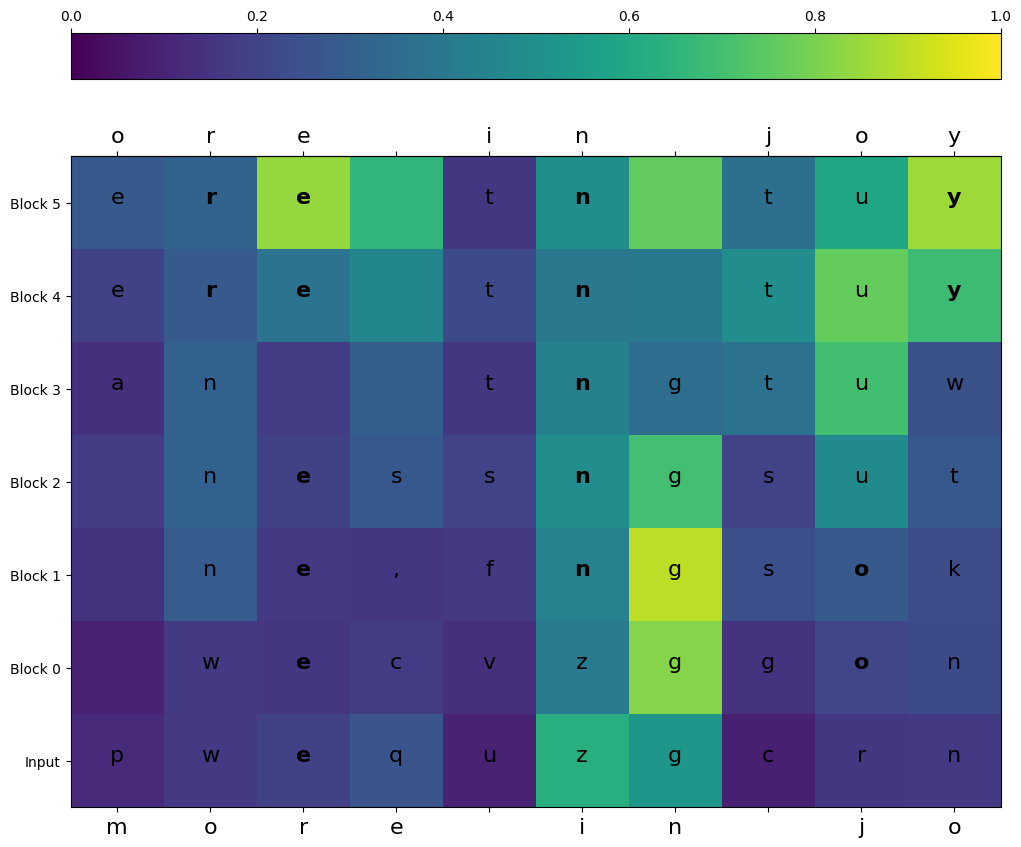

In [ ]:
# Show the logit lens view
logit_lens = LogitLens(encoding_helpers, accessors, 'more in jo', 'ore in joy')
logit_lens.plot()

In [ ]:
# See how it plays out in practice.
tokens = encoding_helpers.tokenize_string(prompt)
n_runs = 10
torch.manual_seed(1337)
for _ in range(n_runs):
    print(repr(tokenizer.decode(m.generate(tokens, max_new_tokens=5)[0].tolist())))

'more in joy\nTha'
'more in joyful '
'more in joyfell'
'more in joy? I '
'more in joy roo'
'more in joy as '
'more in joy whi'
'more in joy\nTha'
'more in joyful '
'more in joy.\nTh'


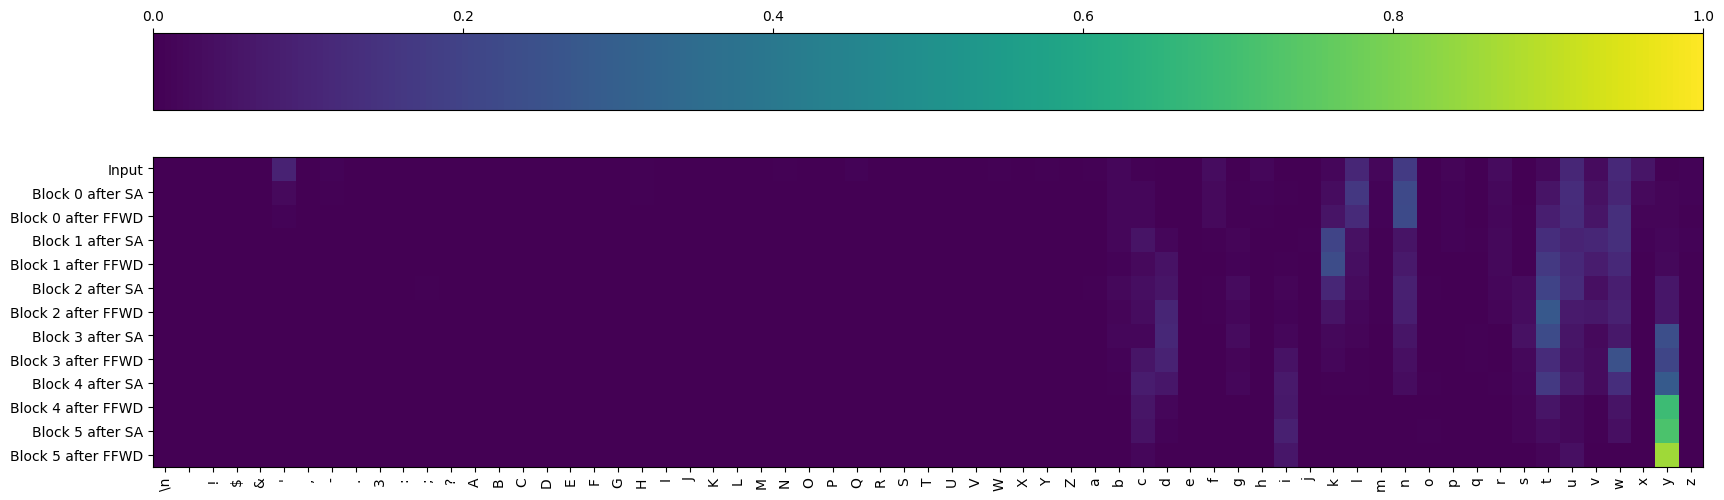

In [ ]:
# Show the block internals view
bia = BlockInternalsAnalysis(accessors, encoding_helpers, prompt=prompt)
bia.plot()

In [ ]:
block_internals_accessors = BlockInternalsAccessors(prompt, encoding_helpers, accessors)

In [ ]:
strings, distances = exp10.strings_with_topk_closest_embeddings(
    queries=block_internals_accessors.input_embedding(),
    k=10,
    largest=False,
)
strings, distances

([['more in jo',
   'more in a ',
   'more in hi',
   'more inexo',
   'more it wo',
   'wore in Ro',
   'more in th',
   ' are in je',
   'more to co',
   'more on He']],
 tensor([[ 0.0000],
         [38.1307],
         [38.3008],
         [38.6413],
         [38.7612],
         [39.4887],
         [39.7856],
         [45.4191],
         [45.8720],
         [45.9124]]))

In [ ]:
for block_idx in range(n_layer):
    strings, distances = exp10.strings_with_topk_closest_proj_outputs(
        block_idx=block_idx,
        t_i=-1,
        queries=block_internals_accessors.proj_output(block_idx=block_idx)[:, -1, :],
        k=10,
        largest=False,
    )
    print(f"Block {block_idx}")
    print(f'--------')
    print('Proj output:')
    for i, s in enumerate(strings[0]):
        print(f'{repr(s)} (distance: {distances[i].item():.3f})')
    print()
    strings, distances = exp10.strings_with_topk_closest_ffwd_outputs(
        block_idx=block_idx,
        t_i=-1,
        queries=block_internals_accessors.ffwd_output(block_idx=block_idx)[:, -1, :],
        k=10,
        largest=False,
    )
    print('FFWD output:')
    for i, s in enumerate(strings[0]):
        print(f'{repr(s)} (distance: {distances[i].item():.3f})')
    print()


Block 0
--------
Proj output:
'more in jo' (distance: 0.000)
' men in jo' (distance: 0.777)
' if one jo' (distance: 0.828)
'ur fine jo' (distance: 0.829)
'rich in jo' (distance: 0.892)
'ower no jo' (distance: 0.939)
'nt your jo' (distance: 0.997)
'less in jo' (distance: 1.012)
'ords no jo' (distance: 1.018)
'my true jo' (distance: 1.057)

FFWD output:
'more in jo' (distance: 0.000)
' if one jo' (distance: 0.136)
' men in jo' (distance: 0.142)
'rich in jo' (distance: 0.148)
'ur fine jo' (distance: 0.152)
' of our jo' (distance: 0.154)
'nt your jo' (distance: 0.158)
'ower no jo' (distance: 0.164)
'less in jo' (distance: 0.165)
' on the jo' (distance: 0.167)

Block 1
--------
Proj output:
'more in jo' (distance: 0.000)
' men in jo' (distance: 1.136)
'rich in jo' (distance: 1.173)
'less in jo' (distance: 1.216)
'York in ju' (distance: 1.815)
'part in ju' (distance: 1.823)
'will in ju' (distance: 1.885)
'ight in ju' (distance: 1.885)
'ceed in ju' (distance: 1.893)
'I do in ju' (distance: 1.

In [ ]:
sim_out, model_out = ss_sim.simulate('more in jo')

In [ ]:
print('Simulation   Model')
for i, (token, prob) in enumerate(sim_out):
    model_token, model_prob = model_out[i]
    print(f'{repr(token)} {prob:.3f}    {repr(model_token)} {model_prob:.3f}')


Simulation   Model
'y' 0.601    'y' 0.857
't' 0.166    'i' 0.061
'i' 0.078    'u' 0.041
's' 0.067    'c' 0.016
'u' 0.039    't' 0.013
'm' 0.018    'l' 0.002
'd' 0.011    'o' 0.002
'r' 0.007    's' 0.002
'k' 0.004    'v' 0.002
'l' 0.004    'w' 0.001


## Work for blog post

In [ ]:
output_dir = Path('../artifacts/block_internals_results/sim_strings/slen10/')
r = ResultDataFile(output_dir / 'results_015.json')

In [ ]:
#prompt='changed my'
prompt = 'my most gr'
promt_idx = r.prompt_to_idx[prompt]

r.emb_similar_strings(prompt)

['my most gr',
 'my most sa',
 't, most gr',
 'my most st',
 'e, most gr',
 'ur most gr',
 'is most gr',
 'my most so',
 'my most re',
 'my most he']

In [ ]:
r.proj_similar_strings(prompt, 0)

['my most gr',
 'ur most gr',
 'is most gr',
 'ne most gr',
 'ilst my gr',
 'he most gr',
 'unto my gr',
 'e, most gr',
 't, most gr',
 'yman to gr']

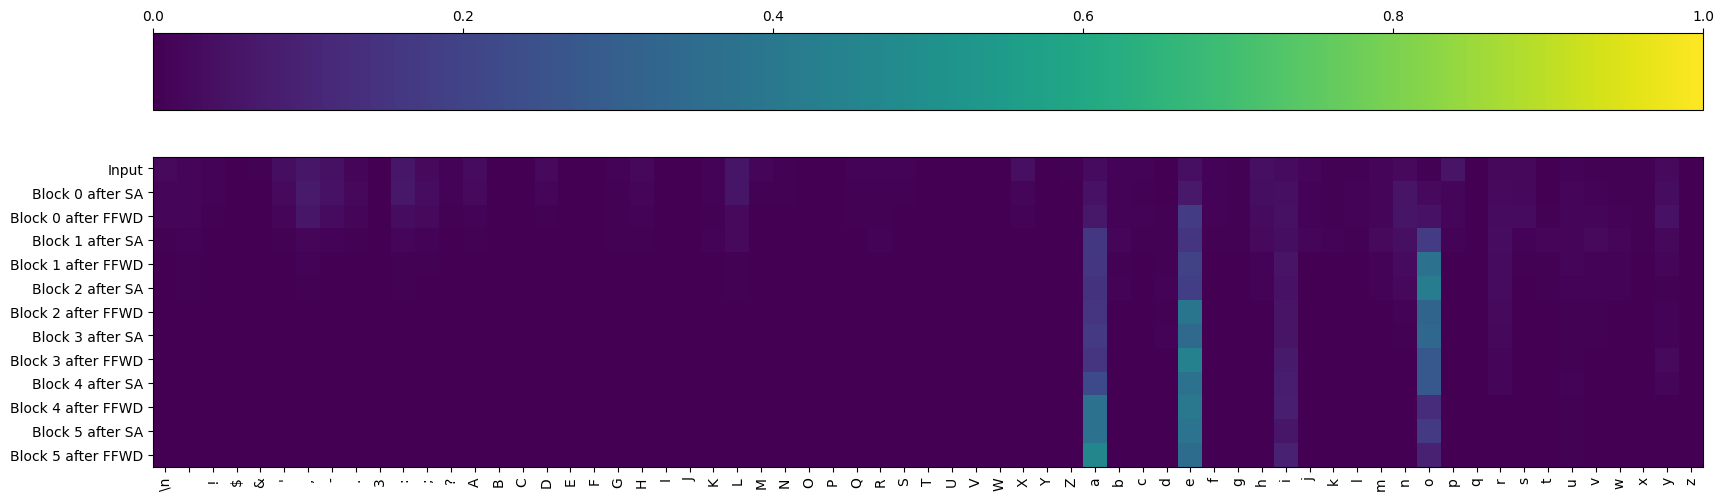

In [ ]:
# Show the block internals view
bia = BlockInternalsAnalysis(accessors, encoding_helpers, prompt=prompt)
bia.plot()

In [ ]:
tokens = encoding_helpers.tokenize_string(prompt)
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
for token, prob in logits.topk_tokens(k=10)[0][-1]:
    print(f'{repr(token)} {prob:.3f}')

'a' 0.460
'e' 0.353
'o' 0.092
'i' 0.090
'u' 0.004
'y' 0.001
'r' 0.000
'l' 0.000
'v' 0.000
'w' 0.000


In [ ]:
# See how it plays out in practice.
tokens = encoding_helpers.tokenize_string(prompt)
n_runs = 10
torch.manual_seed(1337)
for _ in range(n_runs):
    print(repr(tokenizer.decode(m.generate(tokens, max_new_tokens=5)[0].tolist())))

'my most great l'
'my most grant;\n'
'my most grade.\n'
'my most graciou'
'my most great l'
'my most ground.'
'my most great\nA'
'my most graciou'
'my most great e'
'my most growing'


## Analysis of whether there are similar strings of smaller length

In [ ]:
slens = [3, 5, 9, 10]

In [ ]:
strings_n = {
    n: all_unique_substrings(ts.text, n)
    for n in slens
}

In [ ]:
next_token_maps = {
    n: build_next_token_map(
        ts.text, prefix_len=n, vocab_size=tokenizer.vocab_size, stoi=tokenizer.stoi
    )
    for n in slens
}

In [ ]:
for n in slens:
    if list(Path(f'../artifacts/block_internals_results/large_files/slen{n}/').glob('*')) == []:
        print(f"Run `make block_internals_slen{n}_dataset` in the project root to generate the required dataset")

In [ ]:
exps = {
    n: BatchedBlockInternalsExperiment(
        eh=encoding_helpers,
        accessors=accessors,
        strings=strings_n[n],
        output_dir=Path(f'../artifacts/block_internals_results/large_files/slen{n}/'),
        batch_size=10000,
    )
    for n in slens
}

In [ ]:
slicers = {
    n: BatchedBlockInternalsExperimentSlicer(
        exps[n], exps[n].output_dir / 'slices', t_i=-1, combine_n_batches=20
    )
    for n in slens
}

In [ ]:
for n in slens:
    (exps[n].output_dir / 'slices').mkdir(exist_ok=True)

In [ ]:
for n in slens:
    slicers[n].create_slices_if_needed()

In [ ]:
def compare_similar_strings(
    prompt: str,
    block_idx: int,
    compare_to_slen: int,
):
    prompt_accessors = BlockInternalsAccessors(prompt, encoding_helpers, accessors)

    sim_strings_comp, distances_comp = slicers[compare_to_slen].strings_with_topk_closest_proj_outputs(
        block_idx=block_idx,
        queries=prompt_accessors.proj_output(block_idx=block_idx)[:, -1, :],
        k=10,
        largest=False,
    )

    sim_strings, distances = slicers[len(prompt)].strings_with_topk_closest_proj_outputs(
        block_idx=block_idx,
        queries=prompt_accessors.proj_output(block_idx=block_idx)[:, -1, :],
        k=10,
        largest=False,
    )

    print(f"Length {compare_to_slen} similars:   Length {len(prompt)} similars:")
    for i in range(10):
        print(f'{repr(sim_strings_comp[0][i])} {distances_comp[i].item():.3f}        {repr(sim_strings[0][i])} {distances[i].item():.3f}')



After running this a bunch of times, my conclusions from this are:

* Yes it's possible to find similar strings with clear patterns in shorter strings
* The distances are greater when the strings are shorter
* But seeing which shorter strings are similar is illuminating

e.g. for block_idx = 1, looking at similar strings of length 5 vs same length as the prompt:

In [ ]:
prompt = 'my most gr'
compare_similar_strings(prompt, block_idx=1, compare_to_slen=5)

Length 5 similars:   Length 10 similars:
'st go' 4.564        'my most gr' 0.000
'ot gl' 4.591        'ur most gr' 0.949
'st ga' 4.595        'ne most gr' 0.958
'ot ga' 4.609        'he most gr' 1.053
'st gl' 4.629        'is most gr' 1.056
'ot gr' 4.638        'e, most gr' 1.268
'st gr' 4.639        'o, must gr' 1.352
'rt go' 4.647        't, most gr' 1.361
'st gi' 4.662        'be past gr' 1.372
'et go' 4.679        'yet not gr' 1.506


All the length 5 similar strings have `s t`` in common. 

Now look at block 5:

In [ ]:
prompt = 'my most gr'
compare_similar_strings(prompt, block_idx=5, compare_to_slen=5)

Length 5 similars:   Length 10 similars:
'my mo' 4.464        'my most gr' 0.000
'my st' 4.917        'my most st' 3.911
'my br' 4.969        'my most sa' 4.328
'my tr' 4.977        ' my most r' 4.556
'my gr' 5.039        ' my most l' 5.160
'my sw' 5.115        'my high bl' 5.198
'my sc' 5.132        'm thy moth' 5.221
'my wr' 5.140        'mt my mast' 5.225
'my bl' 5.215        'my most he' 5.338
'my tw' 5.267        'my merry m' 5.445


Here the common pattern in the length 5 strings is `my `.

I think this says something. The closest length 5 strings could have been any substring of the full prompt. Seeing what gets picked must be meaningful.

Let's try with length 3:

In [ ]:
prompt = 'my most gr'
compare_similar_strings(prompt, block_idx=1, compare_to_slen=3)

Length 3 similars:   Length 10 similars:
' gn' 6.114        'my most gr' 0.000
' gy' 6.142        'ur most gr' 0.949
' gl' 6.156        'ne most gr' 0.958
' gr' 6.166        'he most gr' 1.053
' gu' 6.202        'is most gr' 1.056
' gh' 6.218        'e, most gr' 1.268
' go' 6.231        'o, must gr' 1.352
' ga' 6.232        't, most gr' 1.361
' ge' 6.267        'be past gr' 1.372
' gi' 6.397        'yet not gr' 1.506


Greater distance but still, a pattern. And block 5:

In [ ]:
prompt = 'my most gr'
compare_similar_strings(prompt, block_idx=5, compare_to_slen=3)

Length 3 similars:   Length 10 similars:
'mys' 6.682        'my most gr' 0.000
'my-' 6.722        'my most st' 3.911
'ms-' 7.015        'my most sa' 4.328
'myr' 7.065        ' my most r' 4.556
'mso' 7.115        ' my most l' 5.160
"my'" 7.123        'my high bl' 5.198
'my?' 7.148        'm thy moth' 5.221
'mfu' 7.158        'mt my mast' 5.225
'moc' 7.168        'my most he' 5.338
"ms'" 7.214        'my merry m' 5.445


A different pattern, but still a pattern.

Let's see if we can do this with just the length 10 data and not have to generate all the block internals data for the other string lengths from scratch. 

As a prereq, let's first see if the intermediate values for substrings within a longer string are the same as the values that would have been produced for those substrings on their own.

In [ ]:
# Show that for the common letters, the intermediates for a substring
# are the same as those in a longer string.
prompt_short = 'my mo'
prompt_long = 'my most gr'

bia_short = BlockInternalsAccessors(prompt_short, encoding_helpers, accessors)
bia_long = BlockInternalsAccessors(prompt_long, encoding_helpers, accessors)

for t_i in range(len(prompt_short)):
    for block_idx in range(n_layer):
        test_close(
            bia_short.proj_output(block_idx=block_idx)[0, t_i, :],
            bia_long.proj_output(block_idx=block_idx)[0, t_i, :],
        )
        test_close(
            bia_short.ffwd_output(block_idx=block_idx)[0, t_i, :],
            bia_long.ffwd_output(block_idx=block_idx)[0, t_i, :],
        )

It passes, so this shows we can use the values at the other t_i's from the slen10 dataset. Let's try it. 

In [ ]:
full_slen=10
target_exp = exps[full_slen]

In [ ]:
def compare_similar_strings2(
    prompt: str,
    block_idx: int,
    compare_to_slen: int,
):
    """Same as compare_similar_strings() above but just uses a single experiment."""
    prompt_accessors = BlockInternalsAccessors(prompt, encoding_helpers, accessors)

    # indexing `compare_to_slen - 1` below because slicers2 is indexed
    # by t_i, not string length
    sim_strings_comp, distances_comp = target_exp.strings_with_topk_closest_proj_outputs(
        block_idx=block_idx,
        t_i=compare_to_slen - 1,
        queries=prompt_accessors.proj_output(block_idx=block_idx)[:, -1, :],
        k=10,
        largest=False,
    )

    sim_strings, distances = exps[len(prompt)].strings_with_topk_closest_proj_outputs(
        block_idx=block_idx,
        t_i=-1,
        queries=prompt_accessors.proj_output(block_idx=block_idx)[:, -1, :],
        k=10,
        largest=False,
    )

    print(f"Length {compare_to_slen} similars:   Length {len(prompt)} similars:")
    for i in range(10):
        print(f'{repr(sim_strings_comp[0][i][:compare_to_slen])} {distances_comp[i].item():.3f}        {repr(sim_strings[0][i])} {distances[i].item():.3f}')


In [ ]:
prompt = 'my most gr'
compare_similar_strings2(prompt, block_idx=5, compare_to_slen=5)

Length 5 similars:   Length 10 similars:
'my mo' 4.464        'my most gr' 0.000
'my st' 4.917        'my most st' 3.911
'my br' 4.969        'my most sa' 4.328
'my tr' 4.977        ' my most r' 4.556
'my gr' 5.039        ' my most l' 5.160
'my sw' 5.115        'my high bl' 5.198
'my sc' 5.132        'm thy moth' 5.221
'my wr' 5.140        'mt my mast' 5.225
'my bl' 5.215        'my most he' 5.338
'my tw' 5.267        'my merry m' 5.445


Notice that this is the same as the output above when we compared to a length 5 experiment's outputs!

And now we can do it for other lengths without having to run experiments for all of them.

In [ ]:
prompt = 'my most gr'
compare_similar_strings2(prompt, block_idx=5, compare_to_slen=9)

Length 9 similars:   Length 10 similars:
'my most r' 2.754        'my most gr' 0.000
'my most l' 3.517        'my most st' 3.911
'my most h' 3.795        'my most sa' 4.328
'm my mout' 4.802        ' my most r' 4.556
'm thy mot' 4.808        ' my most l' 5.160
'm, my mot' 4.832        'my high bl' 5.198
'y most gr' 4.976        'm thy moth' 5.221
'my most g' 5.051        'mt my mast' 5.225
'mes my br' 5.177        'my most he' 5.338
'm my moth' 5.252        'my merry m' 5.445


## Try out loading with mmap_mode

Set up a query:

In [ ]:
prompt = 'my most gr'
prompt_accessors = BlockInternalsAccessors(prompt, encoding_helpers, accessors)
query = prompt_accessors.proj_output(block_idx=0)[:, -1, :]

Time loading a full batch from slen10 the regular way and subtracting the query:

In [ ]:
%%timeit
batch = torch.load(exps[10].output_dir / 'proj_output-000-00.pt')
batch - query

28.4 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now load with `mmap=True` and try again:

In [ ]:
%%timeit
batch = torch.load(str(exps[10].output_dir / 'proj_output-000-00.pt'), mmap=True)
batch - query

11.8 ms ± 56.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Ooh, it's way faster. Let's see if we can load multiple batches, cat them and do the subtraction:

In [ ]:
%%timeit
batch1 = torch.load(str(exps[10].output_dir / 'proj_output-000-00.pt'), mmap=True)
batch2 = torch.load(str(exps[10].output_dir / 'proj_output-001-00.pt'), mmap=True)
batch3 = torch.load(str(exps[10].output_dir / 'proj_output-002-00.pt'), mmap=True)

big_batch = torch.cat([batch1, batch2, batch3])
big_batch - query

52.1 ms ± 637 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Wow. OK, this is a big deal. We did 3 batches in 51ms vs 28.ms for just one batch in the regular way. And I suspect this scales non-linearly. Let's try it with all the batches:


In [ ]:
%%timeit
big_batch = torch.cat([
    torch.load(str(exps[10]._proj_output_filename(batch_idx=batch_idx, block_idx=0)), mmap=True)
    for batch_idx in range(exps[10].n_batches)
])
big_batch - query


8.88 s ± 294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So 8.88s for 86 batches. Memory usage peaked at 25GB during the run but went up and down and settled back down to where it was before the run started. 

But that's 103ms per batch which seems slower than just loading each batch one at a time. But the computation is simpler (no need for `topk_across_batches()` etc). 

Let's try running through all the batches the old way (no mmap) and time it.

In [ ]:
%%timeit
for batch_idx in range(exps[10].n_batches):
    batch = torch.load(str(exps[10]._proj_output_filename(batch_idx=batch_idx, block_idx=0))) # no mmap
    batch - query

3.32 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So this is actually faster. But let's try to do more of the complete operation and do multiple queries:

In [ ]:
# Define prompts and extract the query values
prompts = ['First Citi', 'Citizen:\nB', 'Shyamalan ', 'more in jo']
prompts_exp = BlockInternalsExperiment(encoding_helpers, accessors, prompts)

t_i = -1

queries = prompts_exp.proj_output(block_idx=0)[:, t_i, :]

Time doing the equivalent of strings_with_topk_closest_ffwd_outputs() on the mmaped data:

In [ ]:
%%timeit
big_batch = torch.cat([
    torch.load(str(exps[10]._proj_output_filename(batch_idx=batch_idx, block_idx=0)), mmap=True)
    for batch_idx in range(exps[10].n_batches)
])

n_queries, _ = queries.shape
B, T, _ = big_batch.shape
distances = torch.norm(
    big_batch[:, t_i, :].reshape(B, 1, -1).expand(-1, n_queries, -1) - queries,
    dim=2
)
topk = torch.topk(distances, k=10, dim=0, largest=False)
exps[10].strings_from_indices(topk.indices), topk.values

6.51 s ± 395 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK, that is slow. But I suspect there is some overhead in loading the data the first time. What if we load the data once and then process the queries on the loaded data:

In [ ]:
big_batch = torch.cat([
    torch.load(str(exps[10]._proj_output_filename(batch_idx=batch_idx, block_idx=0)), mmap=True)
    for batch_idx in range(exps[10].n_batches)
])

In [ ]:
%%timeit
n_queries, _ = queries.shape
B, T, _ = big_batch.shape
distances = torch.norm(
    big_batch[:, t_i, :].reshape(B, 1, -1).expand(-1, n_queries, -1) - queries,
    dim=2
)
topk = torch.topk(distances, k=10, dim=0, largest=False)
exps[10].strings_from_indices(topk.indices), topk.values

303 ms ± 8.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Compare that to doing it with a slicer.

In [ ]:
%%timeit
slicers[10].strings_with_topk_closest_proj_outputs(block_idx=0, queries=queries, k=10, largest=False)

471 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We don't have the required methods on the exp class anymore, but if we want to test how long this would have taken without the slicer i.e. on the same data that the mmap version is using but without using mmap, we can resurrect the relevant code:

In [ ]:
# Copy of the code from block_internals, just so we can run it below
def batch_distances(batch: torch.Tensor, queries: torch.Tensor) -> torch.Tensor:
    """Returns the distance between each item in the batch and the queries."""
    assert batch.dim() == 2, f"batch.dim() should be 2, was {batch.dim()}"
    assert queries.dim() == 2, f"query.dim() should be 2, was {queries.dim()}"
    assert (
        batch.shape[-1] == queries.shape[-1]
    ), f"last dimension of batch was {batch.shape[-1]}, which does not match last dimension of queries {queries.shape[-1]}"

    B, _ = batch.shape
    n_queries, _ = queries.shape

    distances = torch.norm(
        # Reshape the batch to a singleton dimension, then expand that dimension
        # by the number of queries. We can then subtract all the queries in one
        # go.
        batch.reshape(B, 1, -1).expand(-1, n_queries, -1) - queries,
        dim=2
    )
    return distances


In [ ]:
%%timeit
n_queries, _ = queries.shape
values, indices = topk_across_batches(
    n_batches=exps[10].n_batches,
    k=10,
    largest=False,
    load_batch=lambda i: torch.load(exps[10]._proj_output_filename(i, block_idx=0))[:, t_i, :],
    process_batch=lambda batch: batch_distances(batch, queries=queries),
)
exps[10].strings_from_indices(indices), values


2.18 s ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The mmap way is a faster than the slicer (303ms vs 471ms) and doesn't require materializing the slices. And it's waaaay faster than doing it without the slicer and without mmap (303ms vs 2.18s).

In summary: 
It seems there is a one-time cost to loading all the batches via: 

```python
big_batch = torch.cat([
    torch.load(str(exps[10]._proj_output_filename(batch_idx=batch_idx, block_idx=0)), mmap=True)
    for batch_idx in range(exps[10].n_batches)
])
```

But this doesn't take up too much memory (fresh Jupyter kernel running just the stuff in this and the previous section has about 13 GB of memory per Activity Monitor). So we can load this once and run a lot of queries very fast. 

Let's check that the results are correct:

In [ ]:
# Do for real so we can compare the results
big_batch = torch.cat([
    torch.load(str(exps[10]._proj_output_filename(batch_idx=batch_idx, block_idx=0)), mmap=True)
    for batch_idx in range(exps[10].n_batches)
])

n_queries, _ = queries.shape
B, T, _ = big_batch.shape
distances = torch.norm(
    big_batch[:, t_i, :].reshape(B, 1, -1).expand(-1, n_queries, -1) - queries,
    dim=2
)
topk = torch.topk(distances, k=10, dim=0, largest=False)
exps[10].strings_from_indices(topk.indices), topk.values

sim_strings, distances = slicers[10].strings_with_topk_closest_proj_outputs(block_idx=0, queries=queries, k=10, largest=False)
test_eq(exps[10].strings_from_indices(topk.indices), sim_strings)
test_close(topk.values, distances)

These test pass, so the output is the same!

### Perf tests for using mmap with the slicer

The analysis above showed that using mmap on the raw batch data is faster than using the slicer. But yesterday I found that just setting mmap=True on the load_batch function when finding closest embeddings made a huge difference. Let's try the same thing for the slicer and see if it makes a difference.

In [ ]:
t_i = -1
queries = prompts_exp.proj_output(block_idx=0)[:, t_i, :]

Though we have a measurement for using the slicer above, let's just replicate it for completeness. Ran this line before making any changes:

In [ ]:
%%timeit
slicers[10].strings_with_topk_closest_proj_outputs(block_idx=0, queries=queries, k=10, largest=False)

482 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK, that's in line with the measurement above. Now let's try it after changing the implementation to use `mmap=True`:

In [ ]:
%%timeit
slicers[10].strings_with_topk_closest_proj_outputs(block_idx=0, queries=queries, k=10, largest=False)

361 ms ± 8.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OK, so it got faster, but it's still not as fast as using the raw batch data with `mmap=True`. So we'll go with that. 

## Perf tests for finding closest embeddings

In [ ]:
exp10 = BatchedBlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=strings_n[10],
    output_dir=Path(f'../artifacts/block_internals_results/large_files/slen10/'),
    batch_size=10000,
)

Measurement before any changes

In [ ]:
%%timeit
exp10.strings_with_topk_closest_embeddings(queries=prompts_exp.embeddings, k=10, largest=False)

4.49 s ± 9.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Simulate loading all the batch data at once and then finding the topk closest strings for all the queries:

In [ ]:
embeddings_data = torch.cat([
    torch.load(str(exp10._embeddings_filename(batch_idx=batch_idx)), mmap=True)
    for batch_idx in range(exp10.n_batches)
])

In [ ]:
# Equivalent of topk_closest_embeddings - slow
B, _, _ = embeddings_data.shape

n_queries, _, _ = prompts_exp.embeddings.shape

distances = batch_distances(
    embeddings_data.reshape(B, -1),
    prompts_exp.embeddings.reshape(n_queries, -1)
)
topk = torch.topk(distances, dim=0, k=k, largest=False)
exp10.strings_from_indices(topk.indices), topk.values


The above was really slow and took a ton of memory.

Verify that the equivalent thing on the proj_out data is still fast:

In [ ]:
proj_out_data = torch.cat([
    torch.load(str(exp10._proj_output_filename(batch_idx=batch_idx, block_idx=0)), mmap=True)
    for batch_idx in range(exp10.n_batches)
])

In [ ]:
n_queries, _ = queries.shape
B, T, _ = proj_out_data.shape
distances = torch.norm(
    proj_out_data[:, t_i, :].reshape(B, 1, -1).expand(-1, n_queries, -1) - queries,
    dim=2
)
topk = torch.topk(distances, k=10, dim=0, largest=False)
exp10.strings_from_indices(topk.indices), topk.values


Yes it is. 

Suspecting the issue is the reshape needed. Show that we can calculate the norm we want without the reshape. 

What the reshape does is stack the embeddings across the T dimension. We have embeddings

$$
e_1, e_2, \ldots, e_T \in \mathbb{R}^{n\_embed}
$$

By stacking them, we get one big embedding:

$$
e_{1:T} \in \mathbb{R}^{T * n\_embed}
$$

We do the same with the queries:

$$
q_1, q_2, \ldots, q_T \in \mathbb{R}^{n\_embed} \rightarrow
q_{1:T} \in \mathbb{R}^{T * n\_embed}
$$

We then want to compute

$$
\Vert e_{1:T} - q_{1:T} \Vert_2 = \sqrt{\sum_{i=1}^{T * n\_embed} (e_{1:T} - q_{1:T})_i^2}
$$

Can we get to this if we only have $e_1, e_2, \ldots, e_T$ and $q_1, q_2, \ldots, q_T$? Yes, we can.

$$
\begin{align}
\Vert e_{1:T} - q_{1:T} \Vert_2 &= \sqrt{\sum_{i=1}^{T * n\_embed} (e_{1:T} - q_{1:T})_i^2} \\
\Vert e_{1:T} - q_{1:T} \Vert_2^2 &= \sum_{i=1}^{T * n\_embed} (e_{1:T} - q_{1:T})_i^2 \\
&=\sum_{i=1}^{n\_embed}(e_{1:T} - q_{1:T})_i^2 + \sum_{i=n\_embed+1}^{2*n\_embed}(e_{1:T} - q_{1:T})_i^2 + \ldots + \sum_{i=(T-1)*n\_embed+1}^{T*n\_embed}(e_{1:T} - q_{1:T})_i^2 \\
&=\sum_{i=1}^{n\_embed}(e_{1} - q_{1})_i^2 + \sum_{i=1}^{n\_embed}(e_{2} - q_{2})_i^2 + \ldots + \sum_{i=1}^{n\_embed}(e_{T} - q_{T})_i^2 \\
&=\Vert e_1 - q_1 \Vert_2^2 + \Vert e_2 - q_2 \Vert_2^2 + \ldots + \Vert e_T - q_T \Vert_2^2 \\
&=\sum_{i=1}^{T}\Vert e_i - q_i \Vert_2^2
\end{align}
$$

So 

$$
\begin{align}
\Vert e_{1:T} - q_{1:T} \Vert_2 &= \sqrt{\sum_{i=1}^{T}\Vert e_i - q_i \Vert_2^2}
\end{align}
$$

Let's check it in code. 

In [ ]:
# Show that we can effectively compute the norm without reshaping
x = torch.randn((100, 5, 384))
B, T, _ = x.shape
q = torch.randn(5, 384)

norm1 = torch.norm(x.reshape(B, -1) - q.reshape(-1), dim=-1)
norm2 = (torch.norm(x - q, dim=-1) ** 2).sum(dim=-1).sqrt()
test_close(norm1, norm2)


Now let's do it with the embeddings

In [ ]:
# Version without reshaping
B, _, _ = embeddings_data.shape

n_queries, _, _ = prompts_exp.embeddings.shape

distances = (
    torch.norm(embeddings_data.unsqueeze(dim=1).expand(-1, n_queries, -1, -1) - prompts_exp.embeddings, dim=-1) ** 2
).sum(dim=-1).sqrt()

topk = torch.topk(distances, dim=0, k=10, largest=False)
exp10.strings_from_indices(topk.indices), topk.values


: 

The above used so much memory that it crashed the kernel. So this is a no go. I think the fundamental problem is we're computing over a lot more data: all elements of the T dimension vs just one with the proj_outputs/ffwd_outputs. So let's go back to the original way of doing it in batches, but let's see if it helps to load "super batches" by combining several of the batches on disk into one batch in memory.

In [ ]:
# Parameters for creating super batches

k=10
largest=False
combine_n_batches = 5

batch_size = exp10.batch_size * combine_n_batches
n_batches = math.ceil(len(exp10.strings) / batch_size)
queries = prompts_exp.embeddings


In [ ]:
%%timeit
def _load_batch(batch_idx: int):
    start = batch_idx * combine_n_batches
    end = min((batch_idx + 1) * combine_n_batches, exp10.n_batches)

    batch = torch.cat([
        torch.load(
            str(exp10._embeddings_filename(batch_idx=i)),
            mmap=True,
        )
        for i in range(start, end)
    ])
    return batch

n_queries, _, _ = queries.shape

def _process_batch(batch: torch.Tensor) -> torch.Tensor:
    B, _, _ = batch.shape
    # Batch and queries and both shape (B, s_len, n_embed).
    # For the purposes of finding the closest values, we
    # reshape both the batch and queries to eliminate the
    # s_len dimension, effectively concatenating all the
    # embedding tensors across positions.
    return batch_distances(batch.reshape(B, -1), queries.reshape(n_queries, -1))

values, indices = topk_across_batches(
    n_batches=n_batches,
    k=k,
    largest=largest,
    load_batch=_load_batch,
    process_batch=_process_batch,
)

exp10.strings_from_indices(indices), values

4.19 s ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This helps only a tiny amount. And it seems to get faster the fewer number of batches we combine. So let's just do it with one batch at a time. I added code to load the one batch in the existing implementation with mmap=True and timed it:

In [ ]:
%%timeit
exp10.strings_with_topk_closest_embeddings(queries=prompts_exp.embeddings, k=10, largest=False)

3.34 s ± 46.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is the best result so far so we'll go with this. 